# Analyse Suraj's qPCR data

In [1]:
# The goal is to re-threshold the results and see if that makes them more consistent

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import linregress

In [3]:
color_dict = {'LMNA Internal': 'dimgrey', 'ALFA_LMNA': '#E59948', 'GFP11_LMNA': '#AACF94', 'SpyTag_LMNA': '#60BDCC'}

In [4]:
folder = 'Y:/Suraj/qPCR Data/'

In [5]:
raw_file = '2020-10-22_134431_LAMIN_KI_qPCR_1 RAW.xlsx'

In [6]:
raw = pd.read_excel(folder+raw_file, header=None, sheet_name=None)

In [7]:
# header_position
header_position = 45

In [8]:
def get_dataframe(sheet, header_position):
    
    new_header = sheet.loc[header_position].copy()
    new_header.name = None
    
    df = sheet.iloc[header_position+1:, :].copy()
    df.columns = new_header
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [9]:
# Get sheet names
sheet_names = list(raw.keys())
sheet_names

['Sample Setup',
 'Raw Data',
 'Amplification Data',
 'Multicomponent Data',
 'Results',
 'Melt Curve Raw Data',
 'Melt Curve Result',
 'Reagent Information']

In [10]:
# Sample Setup contains no information

In [11]:
#my_sample_df = pd.read_csv('C:/Users/David Brown/Desktop/qPCR Map.csv')

In [12]:
#Drop Unnamed columns
# my_sample_df = my_sample_df.drop(columns=list(my_sample_df.columns[my_sample_df.columns.str.contains('Unnamed')]))
# my_sample_df.head()

In [13]:
# my_sample_df['Quantity'].unique()

In [14]:
# Convert quantity to numeric (in fmols)
# for n, value in my_sample_df['Quantity'].iteritems():
#     if 'fmol' in  value:
#         my_sample_df.loc[n, 'Quantity'] = value.rstrip('fmol')

# my_sample_df['Quantity'] = pd.to_numeric(my_sample_df['Quantity'], errors='coerce')
# my_sample_df

In [15]:
#Fix 'ALFA-SpyT LMNA Plasmid', by replacing with 'ALFA-SpyT-LMNA Plasmid'
# my_sample_df.replace('ALFA-SpyT LMNA Plasmid', value='ALFA-SpyT-LMNA Plasmid', inplace=True)
# my_sample_df.replace('WT Plasmid Control', value='WT LMNA Plasmid', inplace=True)
# my_sample_df.replace('GS PPI PS', value='GS07 PPI Presort', inplace=True)
# my_sample_df.replace('GS07 PPI ', value='GS07 PPI', inplace=True)
# my_sample_df.replace('AS02 PPI PS', value='AS02 PPI Presort', inplace=True)
# my_sample_df.replace('LP cDNA ', value='LP cDNA', inplace=True)
# my_sample_df.replace('AS02 PPI ', value='AS02 PPI', inplace=True)
# my_sample_df.replace('AS04 PPI ', value='AS04 PPI', inplace=True)

In [16]:
## Save fixed my_sample_df
# my_sample_df.to_csv('my_sample_df.csv')

In [17]:
## Load fixed my_sample_df
my_sample_df = pd.read_csv('my_sample_df.csv')

In [18]:
my_sample_df['Biogroup Name'].unique()

array(['WT LMNA Plasmid', 'None', 'AS02 PPI Presort', 'GS07 PPI Presort',
       'AS04 Biallelic PS', 'SpyT-LMNA Plasmid', 'GFP11-LMNA Plasmid',
       'AS02 PPI', 'AS04 PPI', 'GS07 PPI', 'AS04 Biallelic',
       'ALFA-LMNA Plasmid', 'GFP11-SpyT-LMNA Plasmid',
       'ALFA-SpyT-LMNA Plasmid', 'WT HEK293T cDNA', 'LP cDNA',
       'AS04 LP cDNA', 'NTC', 'RTC', 'AS04 LP PPI Sort',
       'AS04 LP Biallelic Sort', 'GFP11 in GFP(1-10) Presort',
       'GFP11 in GFP(1-10) Sort'], dtype=object)

In [19]:
my_sample_df['Target Name'].unique()

array(['LMNA Internal', 'None', 'SpyTag_LMNA', 'GFP11_LMNA', 'ALFA_LMNA'],
      dtype=object)

In [20]:
# Map hexcodes onto target colors
my_sample_df['Target Color'] = my_sample_df['Target Name'].map(color_dict)

## Step 1 - Annotate the Amplification Data

In [21]:
amplification_data = raw[sheet_names[2]]

amplification_df = get_dataframe(amplification_data, header_position)
amplification_df

,Well,Well Position,Cycle,Target Name,Rn,Delta Rn
0,1,A1,1,s,39208.7,-888.22
1,1,A1,2,s,39939.5,-410.773
2,1,A1,3,s,40640.1,36.6141
3,1,A1,4,s,40878.5,21.7008
4,1,A1,5,s,40956.8,-153.244
...,...,...,...,...,...,...
15355,384,P24,36,sample,475503,365495
15356,384,P24,37,sample,492822,382932
15357,384,P24,38,sample,506859,397087
15358,384,P24,39,sample,517936,408281


In [22]:
# Annotate raw data with useful information, Sample Name, Biogroup Name, Target Name, Target Color, Task, Quantity
info = my_sample_df.loc[:,['Well Position',
                           'Sample Name',
                           'Biogroup Name', 
                           'Target Name', 
                           'Target Color', 
                           'Task', 
                           'Quantity']]

In [23]:
# Map info onto amplification_data based on 'Well Position'.
amplification_df = amplification_df.merge(info, on='Well Position')
amplification_df.drop(columns=['Target Name_x'], inplace=True)
amplification_df.rename(columns={'Target Name_y':'Target Name'}, inplace=True)
amplification_df

,Well,Well Position,Cycle,Rn,Delta Rn,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity
0,1,A1,1,39208.7,-888.22,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
1,1,A1,2,39939.5,-410.773,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
2,1,A1,3,40640.1,36.6141,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
3,1,A1,4,40878.5,21.7008,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
4,1,A1,5,40956.8,-153.244,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15355,384,P24,36,475503,365495,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN
15356,384,P24,37,492822,382932,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN
15357,384,P24,38,506859,397087,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN
15358,384,P24,39,517936,408281,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN


In [24]:
# Plot the amplification data by Primer Set
grouped = amplification_df.groupby(by=['Target Name', 'Task', 'Biogroup Name', 'Sample Name', 'Well Position'])

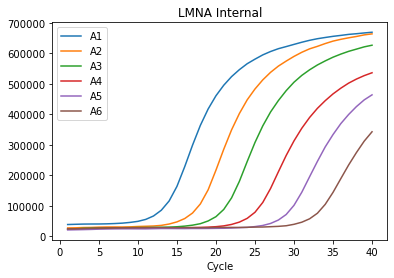

In [25]:
# Plot the amplification data by Primer Set
grouped = amplification_df.groupby(by=['Target Name', 'Task', 'Biogroup Name', 'Sample Name', 'Well Position'])

target_choice = 'LMNA Internal'
task_choice   = 'Standard'

fig, ax = plt.subplots()

for keys, group in grouped:
    
    # get identifiers for each group
    (target, task, biogroup,  sample, well) = keys
    
    if (target == target_choice) and (task == task_choice):
        
        group.plot(x='Cycle', y='Rn', ax=ax, label=well);
        
plt.title(target_choice);
plt.show()

In [26]:
# Plot data of interest based on a dictionary
def plot_subset(df, x, y, conditions: dict):
    
    keys   = list(conditions.keys())
    values = list(conditions.values())
    
    df = df[(df[conditions.keys()] == values).all(1)]
    
    grouped = df.groupby('Well Position')
    
    fig, ax = plt.subplots()

    # Find matching groups
    for well, group in grouped:

        group.plot(x=x, y=y, ax=ax, label=well);

    plt.title(conditions['Target Name']);
    plt.show()

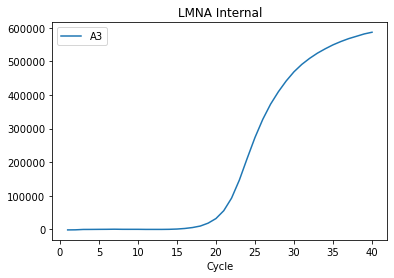

In [27]:
conditions = {'Target Name': 'LMNA Internal', 'Well Position':'A3'}
plot_subset(amplification_df, 'Cycle', 'Delta Rn', conditions)

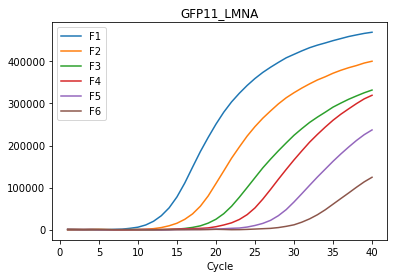

In [28]:
conditions = {'Target Name': 'GFP11_LMNA', 'Biogroup Name':'GFP11-LMNA Plasmid', 'Task':'Standard'}
plot_subset(amplification_df, 'Cycle', 'Delta Rn', conditions)

In [29]:
# def subset_by_options(options, keys):

#     conditions = []

#     for pair in zip(options, keys):
#         conditions.append(if_check(*pair))

#     return tuple(conditions)

# # Check (option, value) pairs match if given.
# def if_check(option, value):
#     if option:
#         return option == value
#     else:
#         return True

# import functools
# def conjunction(*conditions):
#     return functools.reduce(np.logical_and, conditions)

## Step 2 - Re-threshold the data

In [30]:
for n, name in enumerate(sheet_names):
    print(n, name)

0 Sample Setup
1 Raw Data
2 Amplification Data
3 Multicomponent Data
4 Results
5 Melt Curve Raw Data
6 Melt Curve Result
7 Reagent Information


In [31]:
## What are the thresholds that were used?
original_results = raw[sheet_names[4]]

original_results = get_dataframe(original_results, header_position)
original_results

## Annotate original_results
original_results.update(info)

## Still have to add 'Biogroup Name'
original_results = original_results.merge(info.loc[:,['Well Position','Biogroup Name']], on='Well Position')

In [32]:
original_results

,Well,Well Position,Omit,Sample Name,Target Name,Task,Reporter,Quencher,CT,Ct Mean,...,Cq Conf,CQCONF,EXPFAIL,HIGHSD,MTP,Tm1,Tm2,Tm3,Tm4,Biogroup Name
0,1,A1,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,10.7819,23.1243,...,0.917608,N,N,Y,N,85.6508,NaN,NaN,NaN,WT LMNA Plasmid
1,2,A2,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,14.7766,23.1243,...,0.892489,N,N,Y,N,85.6508,NaN,NaN,NaN,WT LMNA Plasmid
2,3,A3,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,18.2721,23.1243,...,0.921872,N,N,Y,N,85.7636,NaN,NaN,NaN,WT LMNA Plasmid
3,4,A4,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,22.4681,23.1243,...,0.969774,N,N,Y,N,85.7636,NaN,NaN,NaN,WT LMNA Plasmid
4,5,A5,false,WT LMNA Plasmid,LMNA Internal,Standard,SYBR,None,26.6304,23.1243,...,0.970196,N,N,Y,N,85.8691,NaN,NaN,NaN,WT LMNA Plasmid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,P20,false,None,None,None,SYBR,None,Undetermined,27.6988,...,0,Y,N,N,N,92.5387,NaN,NaN,NaN,None
380,381,P21,false,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11_LMNA,Unknown,SYBR,None,25.5364,27.6988,...,0.988397,N,N,Y,Y,86.9177,79.7982,NaN,NaN,GFP11 in GFP(1-10) Sort
381,382,P22,false,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11_LMNA,Unknown,SYBR,None,25.6383,27.6988,...,0.987371,N,N,Y,Y,86.8047,79.3462,NaN,NaN,GFP11 in GFP(1-10) Sort
382,383,P23,false,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11_LMNA,Unknown,SYBR,None,25.1406,27.6988,...,0.981798,N,N,Y,N,87.0307,NaN,NaN,NaN,GFP11 in GFP(1-10) Sort


In [33]:
original_results.columns

Index(['Well', 'Well Position', 'Omit', 'Sample Name', 'Target Name', 'Task',
       'Reporter', 'Quencher', 'CT', 'Ct Mean', 'Ct SD', 'Quantity',
       'Quantity Mean', 'Quantity SD', 'Y-Intercept', 'R(superscript 2)',
       'Slope', 'Efficiency', 'Automatic Ct Threshold', 'Ct Threshold',
       'Automatic Baseline', 'Baseline Start', 'Baseline End', 'Amp Status',
       'Comments', 'Cq Conf', 'CQCONF', 'EXPFAIL', 'HIGHSD', 'MTP', 'Tm1',
       'Tm2', 'Tm3', 'Tm4', 'Biogroup Name'],
      dtype='object')

In [34]:
original_results[['Well Position', 'Automatic Ct Threshold', 'Ct Threshold']]

,Well Position,Automatic Ct Threshold,Ct Threshold
0,A1,true,11543.6
1,A2,true,11543.6
2,A3,true,11543.6
3,A4,true,11543.6
4,A5,true,11543.6
...,...,...,...
379,P20,true,15593.9
380,P21,true,15593.9
381,P22,true,15593.9
382,P23,true,15593.9


In [35]:
original_results['Ct Threshold'].unique()

array([11543.649907235183, 15593.911055423094], dtype=object)

In [36]:
standard_threshold = original_results['Ct Threshold'].unique()[0]
sample_threshold   = original_results['Ct Threshold'].unique()[1]

In [37]:
def plot_standards(df, x, y, target, by='Biogroup Name'):
    
    grouped = df[(df['Target Name']==target) & (df['Task']=='Standard')].groupby(by)

    for group_name, group in grouped:

        fig, ax = plt.subplots()
        
        thresholds = []

        for well in group['Well Position']:

            amplification_df[amplification_df['Well Position']==well].plot(x, y, ax = ax)
            ax.legend(group['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            
            threshold = original_results[original_results['Well Position']==well]['Ct Threshold'].item()
            thresholds.append(threshold)
            
        # Add unique thresholds to plot
        for threshold in list(set(thresholds)):
            ax.axhline(threshold, c='k', linestyle='--')
            print('threshold=',threshold)

        plt.title(group_name+', '+target+' Primers')
        plt.show()

threshold= 11543.649907235183


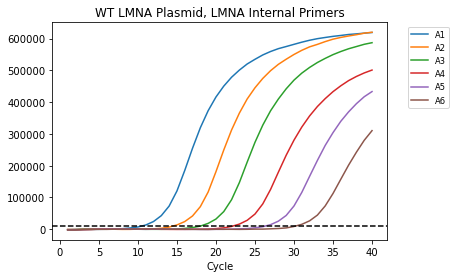

In [38]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='LMNA Internal', by='Biogroup Name')

threshold= 11543.649907235183


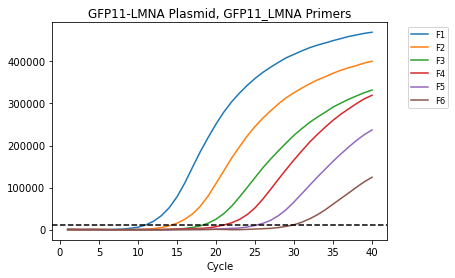

threshold= 11543.649907235183


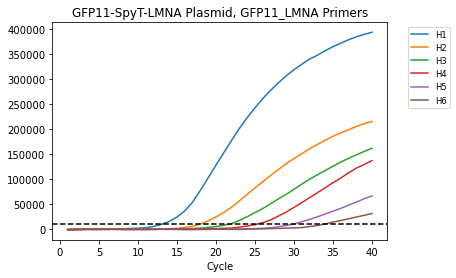

threshold= 11543.649907235183


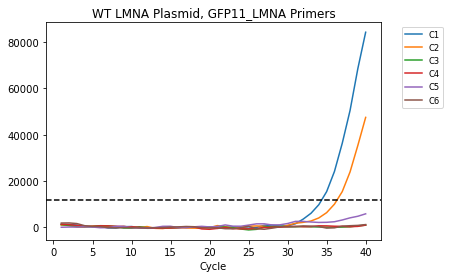

In [39]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='GFP11_LMNA', by='Biogroup Name')

threshold= 11543.649907235183


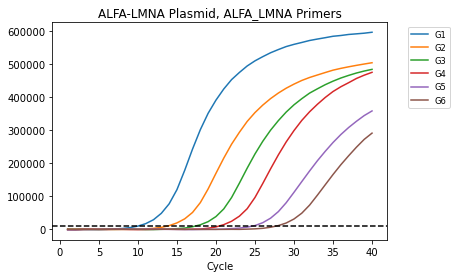

threshold= 11543.649907235183


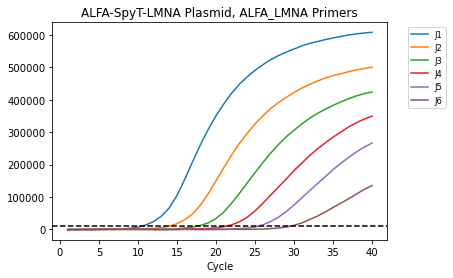

threshold= 11543.649907235183


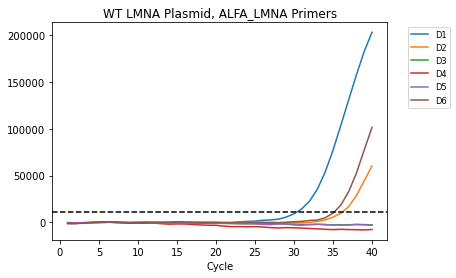

In [40]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='ALFA_LMNA', by='Biogroup Name')

threshold= 11543.649907235183


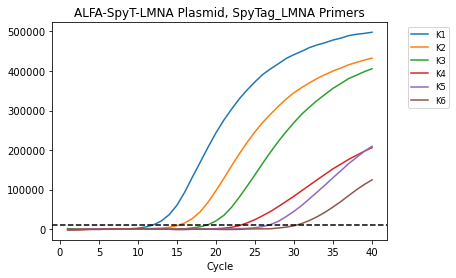

threshold= 11543.649907235183


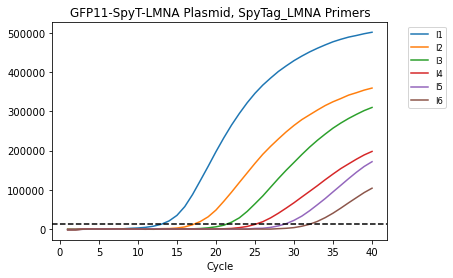

threshold= 11543.649907235183


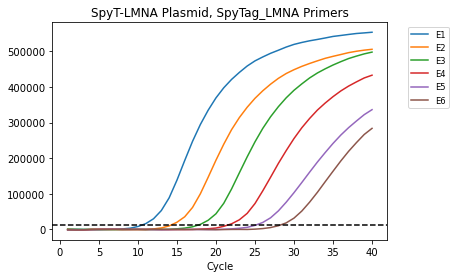

threshold= 11543.649907235183


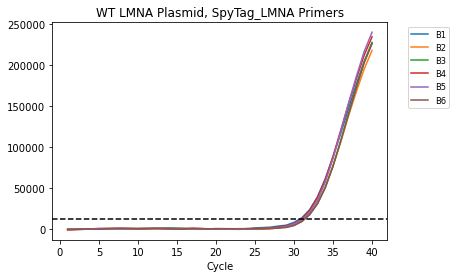

In [41]:
plot_standards(original_results, x='Cycle', y='Delta Rn', target='SpyTag_LMNA', by='Biogroup Name')

In [42]:
## What if we calculate Cts for all wells using the standard_threshold?

In [43]:
# Fit spline
from scipy.interpolate import interp1d

In [44]:
def get_Ct_from_ampdata(xdata, ydata, threshold):
    
    inv_f = interp1d(ydata, xdata, bounds_error=False, fill_value=np.nan)
    
    Ct = inv_f(threshold)
    
    return Ct

In [45]:
def get_Ct_for_well(well, threshold):
    
    xdata = amplification_df[amplification_df['Well Position']==well]['Cycle']
    ydata = amplification_df[amplification_df['Well Position']==well]['Delta Rn']
    
    return get_Ct_from_ampdata(xdata, ydata, threshold)

In [46]:
# Try with some samples
target='LMNA Internal'

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

my_Ct_results                  = pd.DataFrame()
my_Ct_results['Well Position'] = target_wells['Well Position']

Old_Cts       = []
Lo_thresh_Cts = []
Hi_thresh_Cts = []

for well in target_wells['Well Position'].unique():
    xdata = amplification_df[amplification_df['Well Position']==well]['Cycle']
    ydata = amplification_df[amplification_df['Well Position']==well]['Delta Rn']
    
    Old_Ct = original_results[original_results['Well Position']==well]['CT'].item()
    
    Lo_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, standard_threshold)
    Hi_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, sample_threshold)
     
    Old_Cts.append(Old_Ct)
    Lo_thresh_Cts.append(Lo_thresh_Ct)
    Hi_thresh_Cts.append(Hi_thresh_Ct)

my_Ct_results['Original Ct']  = Old_Cts
my_Ct_results['Lo thresh Ct'] = Lo_thresh_Cts
my_Ct_results['Hi thresh Ct'] = Hi_thresh_Cts

my_Ct_results

,Well Position,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,10.781867,10.707516636961287,11.206080395526243
1,A2,14.776569,14.689455560537265,15.18939026280521
2,A3,18.272146,18.190679308041165,18.660424630540927
3,A4,22.468070,22.364042970335397,22.91463401116235
4,A5,26.630426,26.542662209893862,27.09963702561525
5,A6,30.523369,30.410140685732895,31.006286197927157
7,A8,25.558418,25.00824558201031,25.46065465506177
8,A9,25.634232,25.109857433226317,25.558861379917513
9,A10,25.680489,25.16645533098514,25.592600693957436
10,A11,26.165556,25.584217419232502,26.07599460090727


In [47]:
## Repeat for the whole dataset
my_Ct_results                  = pd.DataFrame()
my_Ct_results['Well Position'] = original_results['Well Position']

Old_Cts       = []
Lo_thresh_Cts = []
Hi_thresh_Cts = []

for well in original_results['Well Position'].unique():
    xdata = amplification_df[amplification_df['Well Position']==well]['Cycle']
    ydata = amplification_df[amplification_df['Well Position']==well]['Delta Rn']
    
    Old_Ct = original_results[original_results['Well Position']==well]['CT'].item()
    
    Lo_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, standard_threshold)
    Hi_thresh_Ct = get_Ct_from_ampdata(xdata, ydata, sample_threshold)
     
    Old_Cts.append(Old_Ct)
    Lo_thresh_Cts.append(Lo_thresh_Ct)
    Hi_thresh_Cts.append(Hi_thresh_Ct)

my_Ct_results['Original Ct']  = Old_Cts
my_Ct_results['Lo thresh Ct'] = Lo_thresh_Cts
my_Ct_results['Hi thresh Ct'] = Hi_thresh_Cts

## Now every well has a Ct for all three threshold conditions
my_Ct_results = info.merge(my_Ct_results, on ='Well Position')

In [48]:
my_Ct_results

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.1000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.0100,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.0010,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.0001,26.6304,26.542662209893862,27.09963702561525
...,...,...,...,...,...,...,...,...,...,...
379,P20,None,None,None,NaN,None,NaN,Undetermined,nan,nan
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


## Step 3 - Calculate Standard curves for each threshold conditions

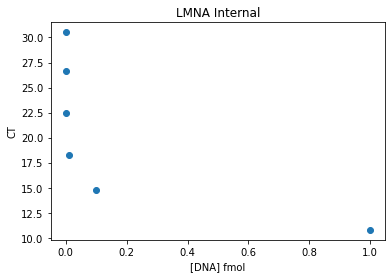

In [49]:
# Fit Standard Curves
target = 'LMNA Internal'
df     =  my_Ct_results

data = df[(df['Target Name']==target) & (df['Task']=='Standard')]

x = data['Quantity']
y = data['Original Ct']

plt.scatter(x,y)
        
plt.title(target)
plt.xlabel('[DNA] fmol')
plt.ylabel('CT')
plt.show()

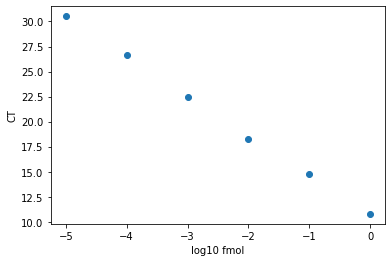

In [50]:
# Fit Standard Curves
target = 'LMNA Internal'
df     =  my_Ct_results

data = df[(df['Target Name']==target) & (df['Task']=='Standard')]

x = data['Quantity']
y = data['Original Ct']

plt.scatter(np.log10(x),y)
        
plt.xlabel('log10 fmol')
plt.ylabel('CT')
plt.show()

-3.956143 10.685050333333333 -0.9997104964965883 1.2570628575736882e-07


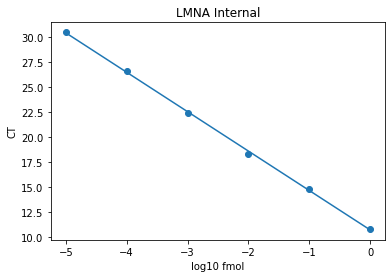

In [51]:
# Fit Standard Curves
target = 'LMNA Internal'
df     =  my_Ct_results

data = df[(df['Target Name']==target) & (df['Task']=='Standard')]

x = np.array(np.log10(data['Quantity']), dtype='float')
y = np.array(data['Original Ct'], dtype='float')

plt.scatter(x, y);

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(slope, intercept, r_value, p_value)

fit = slope * x + intercept

plt.plot(x, fit)
        
plt.title(target)
plt.xlabel('log10 fmol')
plt.ylabel('CT')
plt.show()

### For every, target, standard, threshold, we need a slope and and intercept.

We may as well save the r_value, p_value and std_err too

In [52]:
standards = my_Ct_results[my_Ct_results['Task']=='Standard']

grouped = standards.groupby(by=['Target Name', 'Biogroup Name'])

pairs = []

for pair, group in grouped:
    #print(pair)
    pairs.append(pair)

pairs
# These will not all be used to quantify.

[('ALFA_LMNA', 'ALFA-LMNA Plasmid'),
 ('ALFA_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('ALFA_LMNA', 'WT LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('GFP11_LMNA', 'WT LMNA Plasmid'),
 ('LMNA Internal', 'WT LMNA Plasmid'),
 ('SpyTag_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'WT LMNA Plasmid')]

In [53]:
valid_pairs = pairs[0:2] + pairs[3:5] + pairs[6:10]
valid_pairs

[('ALFA_LMNA', 'ALFA-LMNA Plasmid'),
 ('ALFA_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-LMNA Plasmid'),
 ('GFP11_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('LMNA Internal', 'WT LMNA Plasmid'),
 ('SpyTag_LMNA', 'ALFA-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'GFP11-SpyT-LMNA Plasmid'),
 ('SpyTag_LMNA', 'SpyT-LMNA Plasmid')]

In [54]:
def fit_standards(quantities, CTs, plot=True, color='b'):

    x = np.array(np.log10(quantities), dtype='float')
    y = np.array(CTs, dtype='float')

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    fit = slope * x + intercept

    if plot:
        plt.scatter(x, y, c=color);
        plt.gca().plot(x, fit, c=color)
        
    return slope, intercept, r_value, p_value, std_err

In [55]:
standards

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.00000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.10000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.01000,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.00100,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.00010,26.6304,26.542662209893862,27.09963702561525
...,...,...,...,...,...,...,...,...,...,...
241,K2,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,0.10000,15.474,15.395050656585367,15.97858729709941
242,K3,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,0.01000,18.9983,19.018772396518067,19.4475749868415
243,K4,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,0.00100,23.383,23.365761654057383,23.959493488117577
244,K5,ALFA-SpyT-LMNA Plasmid,ALFA-SpyT-LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,0.00010,26.9692,26.97038089741482,27.470681992577756


In [56]:
data

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.00000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.10000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.01000,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.00100,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.00010,26.6304,26.542662209893862,27.09963702561525
5,A6,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.00001,30.5234,30.410140685732895,31.006286197927157


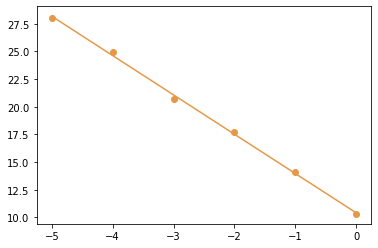

In [57]:
target   = 'ALFA_LMNA'
biogroup = 'ALFA-LMNA Plasmid'
Ct_type  = 'Original Ct'

data = standards[(standards['Target Name']==target) & (standards['Biogroup Name']==biogroup)]

quantities = data['Quantity']
CTs        = data[Ct_type]
color      = data['Target Color'].unique()[0]

slope, intercept, r_value, p_value, std_err = fit_standards(quantities, CTs, plot=True, color=color)

In [58]:
fit_data = []

for Ct_type in ['Original Ct', 'Lo thresh Ct', 'Hi thresh Ct']:
    
    for target, biogroup in valid_pairs:
        
        data = standards[(standards['Target Name']==target) & (standards['Biogroup Name']==biogroup)]

        quantities = data['Quantity']
        CTs        = data[Ct_type]
        color      = data['Target Color'].unique()[0]

        slope, intercept, r_value, p_value, std_err = fit_standards(quantities, CTs, plot=False)
        
        row = [target, biogroup, color, Ct_type, slope, intercept, r_value, p_value, std_err]
        
        fit_data.append(row)

fit_df = pd.DataFrame (fit_data, columns=['Target Name', 'Biogroup Name', 'Target Color', 'Ct Type', 'Slope', 'Intercept', 'R value', 'P value', 'Standard Error'])
fit_df

,Target Name,Biogroup Name,Target Color,Ct Type,Slope,Intercept,R value,P value,Standard Error
0,ALFA_LMNA,ALFA-LMNA Plasmid,#E59948,Original Ct,-3.553127,10.419796,-0.999164,1.047281e-06,0.072676
1,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,#E59948,Original Ct,-3.808705,10.488753,-0.999429,4.882395e-07,0.064358
2,GFP11_LMNA,GFP11-LMNA Plasmid,#AACF94,Original Ct,-3.717449,10.789487,-0.997798,7.267024e-06,0.123550
3,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,#AACF94,Original Ct,-4.116008,13.614589,-0.999355,6.237825e-07,0.073949
4,LMNA Internal,WT LMNA Plasmid,dimgrey,Original Ct,-3.956143,10.685050,-0.999710,1.257063e-07,0.047608
5,SpyTag_LMNA,ALFA-SpyT-LMNA Plasmid,#60BDCC,Original Ct,-3.745522,11.874832,-0.999407,5.272379e-07,0.064519
6,SpyTag_LMNA,GFP11-SpyT-LMNA Plasmid,#60BDCC,Original Ct,-3.808848,13.284353,-0.998910,1.781058e-06,0.088986
7,SpyTag_LMNA,SpyT-LMNA Plasmid,#60BDCC,Original Ct,-3.562069,10.616604,-0.999684,1.493535e-07,0.044754
8,ALFA_LMNA,ALFA-LMNA Plasmid,#E59948,Lo thresh Ct,-3.566138,10.337121,-0.999044,1.369358e-06,0.078007
9,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,#E59948,Lo thresh Ct,-3.814102,10.431306,-0.999440,4.705620e-07,0.063857


In [59]:
## With the slope and intercept for a given standard, we can quantify our samples

## We want to quantify every sample, based on each relevant standard curve

## This will involve intersecting 'my_Ct_results' with 'fit_df'

In [60]:
target   = 'GFP11_LMNA'

fit_df[fit_df['Target Name']==target]

# There are two biogroups, and three Ct Types for this target

,Target Name,Biogroup Name,Target Color,Ct Type,Slope,Intercept,R value,P value,Standard Error
2,GFP11_LMNA,GFP11-LMNA Plasmid,#AACF94,Original Ct,-3.717449,10.789487,-0.997798,7.267024e-06,0.123550
3,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,#AACF94,Original Ct,-4.116008,13.614589,-0.999355,6.237825e-07,0.073949
10,GFP11_LMNA,GFP11-LMNA Plasmid,#AACF94,Lo thresh Ct,-3.723368,10.736368,-0.997254,1.130420e-05,0.138262
11,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,#AACF94,Lo thresh Ct,-4.127428,13.600350,-0.999175,1.020420e-06,0.083875
18,GFP11_LMNA,GFP11-LMNA Plasmid,#AACF94,Hi thresh Ct,-3.765169,11.290355,-0.998116,5.323407e-06,0.115738
19,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,#AACF94,Hi thresh Ct,-4.215219,14.192603,-0.999365,6.041951e-07,0.075129


In [61]:
my_Ct_results[my_Ct_results['Target Name']==target]

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,1.0000,34.3712,34.32270563316416,35.02644262070774
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,0.1000,36.344,36.2947756579007,37.02597826614165
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,0.0100,Undetermined,nan,nan
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,0.0010,Undetermined,nan,nan
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,0.0001,Undetermined,nan,nan
...,...,...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,#AACF94,Unknown,NaN,26.5364,26.048953219212997,26.503262334302196
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


In [62]:
## Try a single case
target   = 'GFP11_LMNA'
biogroup = 'GFP11-LMNA Plasmid'
Ct_type  = 'Original Ct'

fit_data = fit_df[(fit_df['Target Name']==target) & (fit_df['Biogroup Name']==biogroup) & (fit_df['Ct Type']==Ct_type)]

# get slope and intercept from fit_df
[slope, intercept] = fit_data[['Slope', 'Intercept']].values[0]
print(slope, intercept)

-3.7174488571428563 10.789486523809524


In [63]:
# get CT from my_Ct_results
target_Ct_data = my_Ct_results[(my_Ct_results['Target Name']==target)]
Ct_data        = target_Ct_data[Ct_type]

Ct_data        = pd.to_numeric(Ct_data, errors='coerce')
Ct_data

48     34.371200
49     36.344030
50           NaN
51           NaN
52           NaN
         ...    
354    26.536386
380    25.536352
381    25.638279
382    25.140633
383    24.823195
Name: Original Ct, Length: 70, dtype: float64

In [64]:
# Estimate quantities based on CT?
def quant_from_CT(CT, slope, intercept):
    
    quant = (CT - intercept) / slope
    
    return quant    

In [65]:
quant_from_CT(Ct_data, slope, intercept)

48    -6.343521
49    -6.874215
50          NaN
51          NaN
52          NaN
         ...   
354   -4.235942
380   -3.966932
381   -3.994350
382   -3.860483
383   -3.775091
Name: Original Ct, Length: 70, dtype: float64

In [66]:
target_quantitation_df = target_Ct_data.iloc[:,0:6].copy()
target_quantitation_df['Ct Type']  = Ct_type
target_quantitation_df['Quantity'] = quant_from_CT(Ct_data, slope, intercept)
target_quantitation_df['log10 (fmol)'] = 10**target_quantitation_df['Quantity']
target_quantitation_df

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,Quantity,log10 (fmol)
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,-6.343521,4.533978e-07
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,-6.874215,1.335933e-07
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN,NaN
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN,NaN
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN,NaN
...,...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,-4.235942,5.808414e-05
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,-3.966932,1.079117e-04
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,-3.994350,1.013094e-04
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,-3.860483,1.378851e-04


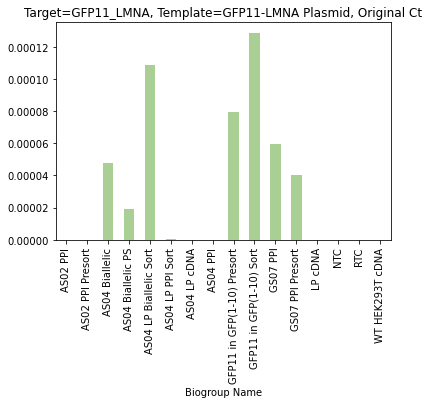

In [67]:
# Plot that sucka
color = target_quantitation_df['Target Color'].unique()[0]

unknowns = target_quantitation_df[target_quantitation_df['Task']!='Standard']
grouped  = unknowns.drop(columns=['Quantity']).groupby('Biogroup Name').mean().plot.bar(color=color)
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

In [68]:
# Write a function for one case
def quantification_on_standards(target, biogroup, Ct_type):
    
    fit_data = fit_df[(fit_df['Target Name']==target) & (fit_df['Biogroup Name']==biogroup) & (fit_df['Ct Type']==Ct_type)]

    # get slope and intercept from fit_df
    [slope, intercept] = fit_data[['Slope', 'Intercept']].values[0]
    
    # get CT from my_Ct_results
    target_Ct_data = my_Ct_results[(my_Ct_results['Target Name']==target)]
    Ct_data        = target_Ct_data[Ct_type]

    Ct_data        = pd.to_numeric(Ct_data, errors='coerce')
    
    target_quantitation_df = target_Ct_data.iloc[:,0:6].copy()
    target_quantitation_df['Ct Type']  = Ct_type
    target_quantitation_df['log10 (fmol)'] = pd.to_numeric(10**quant_from_CT(Ct_data, slope, intercept), errors='coerce')
    
    color = target_quantitation_df['Target Color'].unique()[0]

    unknowns = target_quantitation_df[target_quantitation_df['Task']!='Standard']
    grouped  = unknowns.groupby('Biogroup Name').mean().plot.bar(color=color)
    plt.legend().remove()
    plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

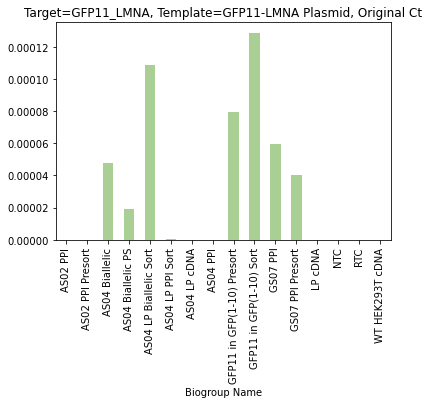

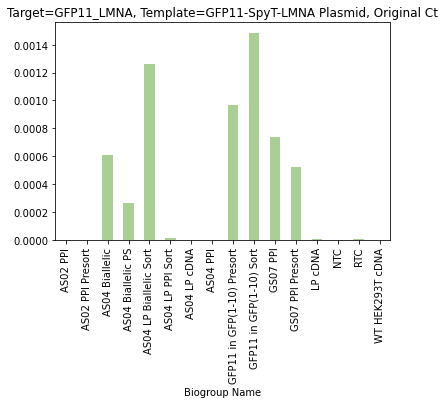

In [69]:
## Using the Original Cts quantitations are an order of magnitute different
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Original Ct')
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Original Ct')

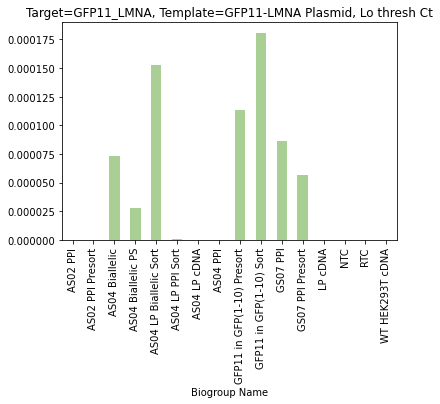

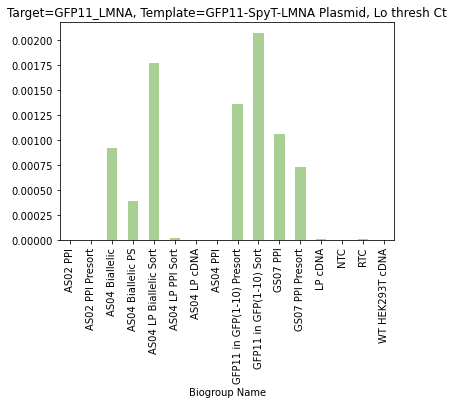

In [70]:
## This is not resolved by altering the threshold method
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Lo thresh Ct')
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Lo thresh Ct')

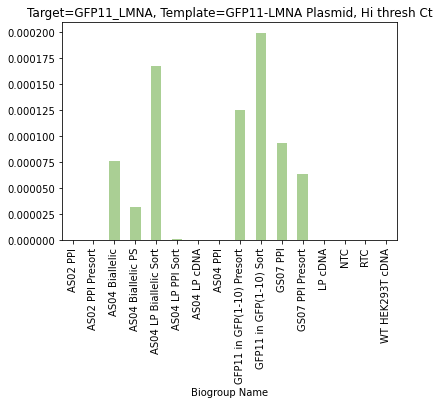

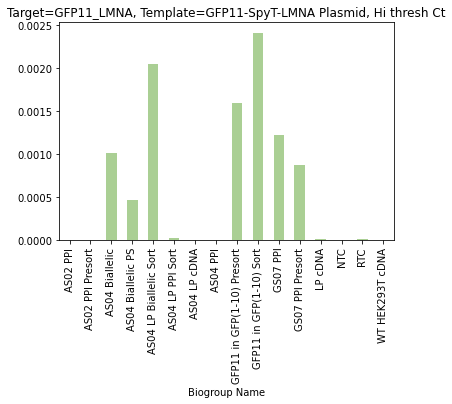

In [71]:
## This is not resolved by altering the threshold method
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Hi thresh Ct')
quantification_on_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Hi thresh Ct')

## Step 4 - Analyse Melt Curves

In [72]:
melt_curve_data = raw[sheet_names[5]]

melt_curve_df = get_dataframe(melt_curve_data, header_position)

melt_curve_df = melt_curve_df.drop(columns=['Target Name']).merge(info, on='Well Position')
melt_curve_df

,Well,Well Position,Reading,Temperature,Fluorescence,Derivative,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity
0,1,A1,1,71.9999,420995,16234.2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
1,1,A1,2,72.2255,417698,16362.5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
2,1,A1,3,72.4512,415390,16506.5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
3,1,A1,4,72.6768,410732,16629,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
4,1,A1,5,72.9024,406955,16699.3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39163,384,P24,98,93.9242,-3433.55,-349.639,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN
39164,384,P24,99,94.1502,-4400.84,-406.404,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN
39165,384,P24,100,94.3763,-3367.71,-437.417,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN
39166,384,P24,101,94.6023,-3821.43,-455.884,GFP11 in GFP(1-10) gRNA2 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN


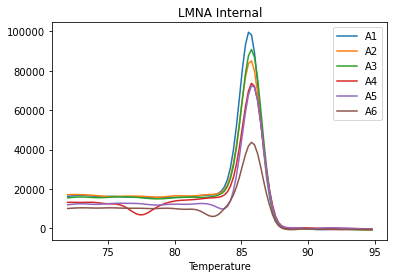

In [73]:
conditions = {'Target Name' : 'LMNA Internal' , 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)

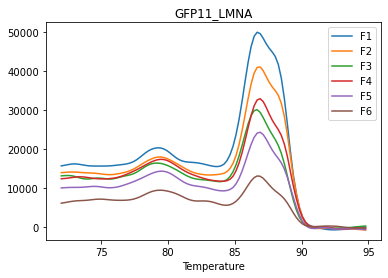

In [74]:
conditions = {'Target Name' : 'GFP11_LMNA', 'Biogroup Name': 'GFP11-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)

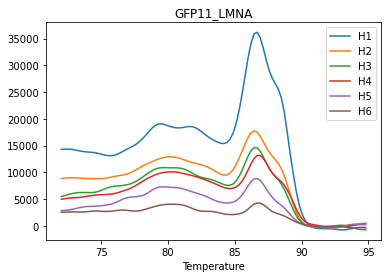

In [75]:
# For the lower concentrations of GFP11-SpyT-LMNA Plasmid, 
# the GFP11_LMNA primer set cannot distinguish between the target and non-specific products
conditions = {'Target Name' : 'GFP11_LMNA', 'Biogroup Name': 'GFP11-SpyT-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)

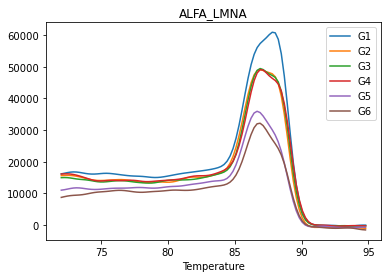

In [76]:
conditions = {'Target Name' : 'ALFA_LMNA', 'Biogroup Name': 'ALFA-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)
# The amplification curves a a bit messier

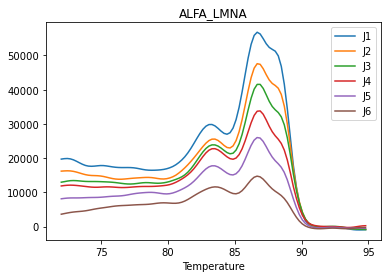

In [77]:

conditions = {'Target Name' : 'ALFA_LMNA', 'Biogroup Name': 'ALFA-SpyT-LMNA Plasmid', 'Task' : 'Standard'}
plot_subset(df=melt_curve_df, x='Temperature', y='Derivative', conditions=conditions)
# Cleaner amplification curves, but a substantial side product

In [78]:
## Save the DataFrames
amplification_df.to_pickle('annotated_amplification_df.pkl')
melt_curve_df.to_pickle('annotated_melt_curve_df.pkl')
my_Ct_results.to_pickle('annotated_Ct_results_df.pkl')
fit_df.to_pickle('annotated_fit_df.pkl')

In [79]:
## Load the local DataFrames
# amplification_df = pd.read_pickle('annotated_amplification_df.pkl')
# melt_curve_df    = pd.read_pickle('annotated_melt_curve_df.pkl')
# my_Ct_results    = pd.read_pickle('annotated_Ct_results_df.pkl')
# fit_df           = pd.read_pickle('annotated_fit_df.pkl')

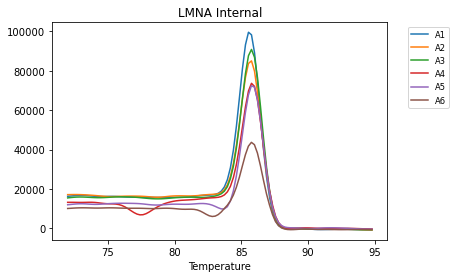

In [80]:
target = 'LMNA Internal'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

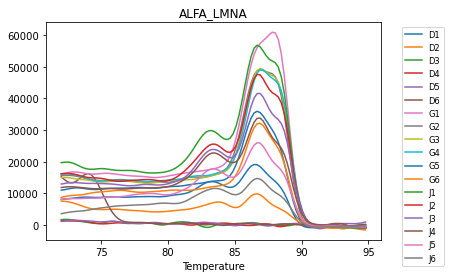

In [81]:
target = 'ALFA_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

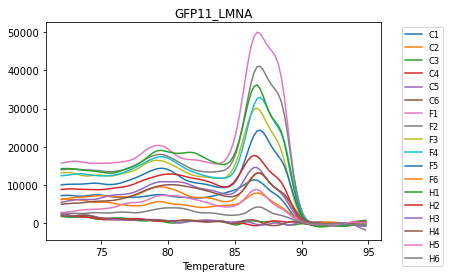

In [82]:
target = 'GFP11_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

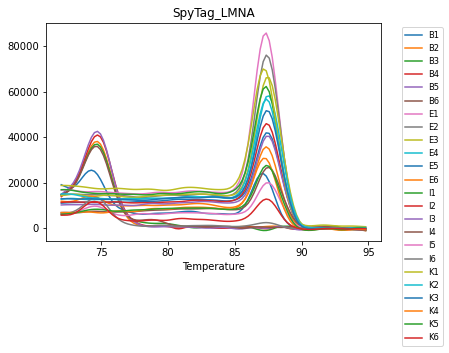

In [83]:
target = 'SpyTag_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

fig, ax = plt.subplots()

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative', ax = ax)
    ax.legend(standard_wells['Well Position'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title(target)
plt.show()

In [84]:
## Which rows have the side hit ?

C:\Users\PythonWork\envs\HybriSeq\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\PythonWork\envs\HybriSeq\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\PythonWork\envs\HybriSeq\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

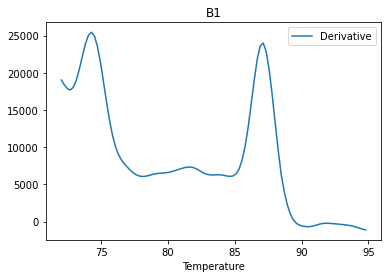

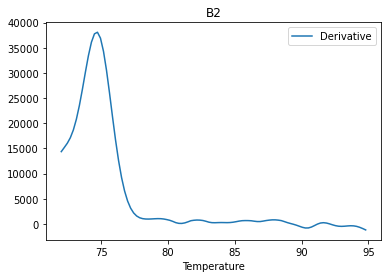

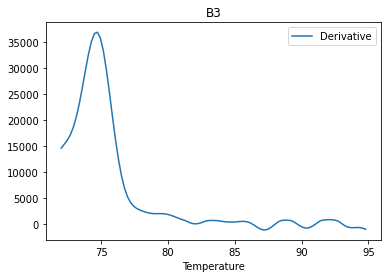

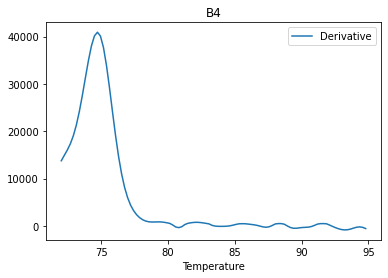

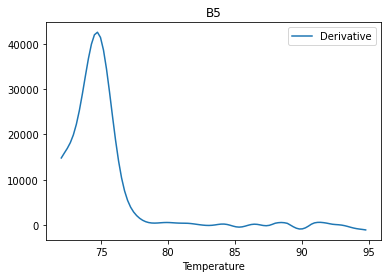

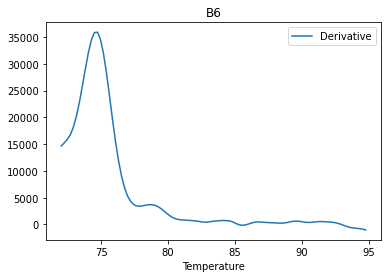

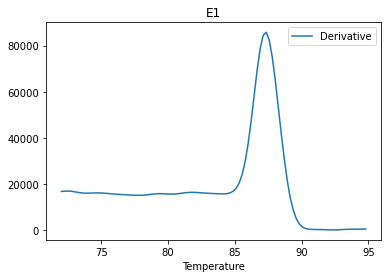

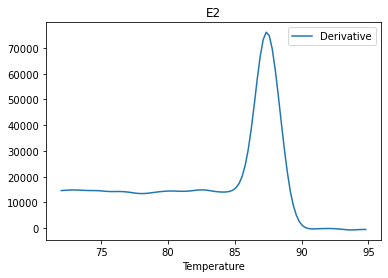

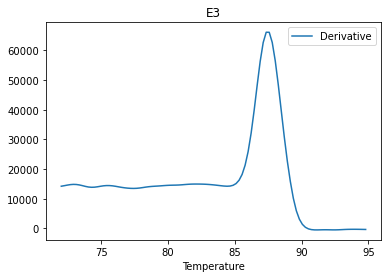

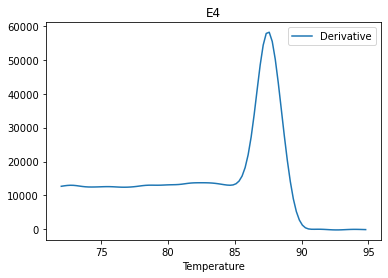

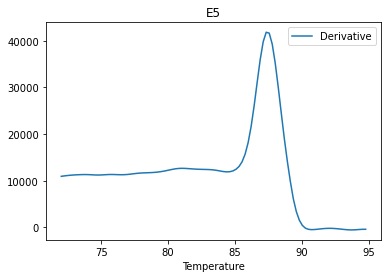

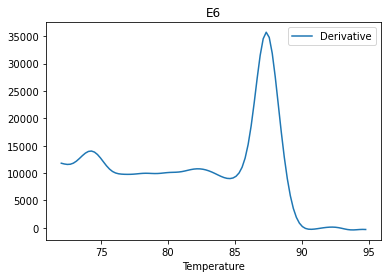

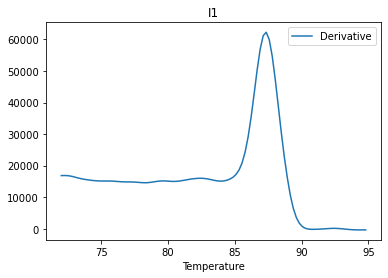

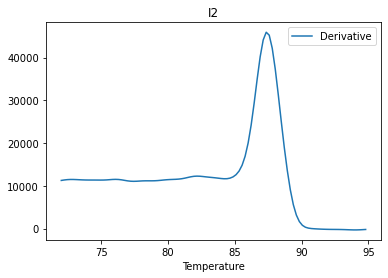

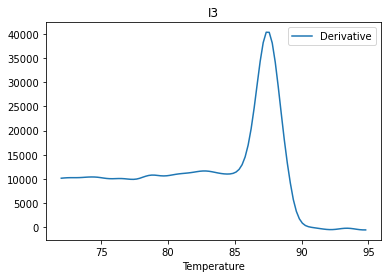

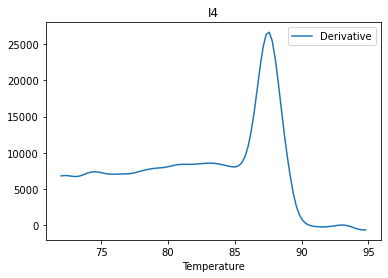

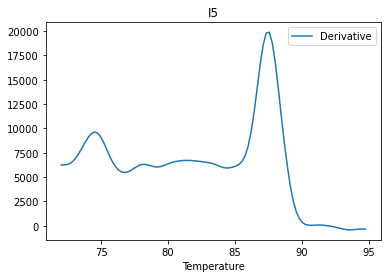

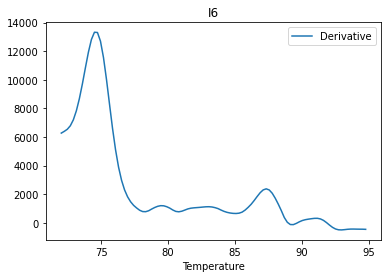

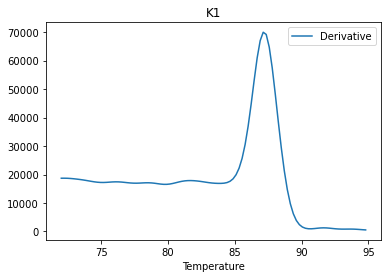

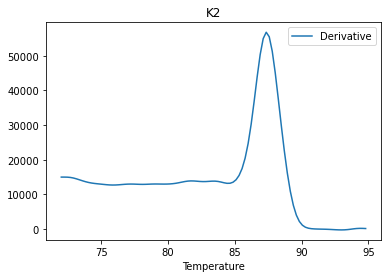

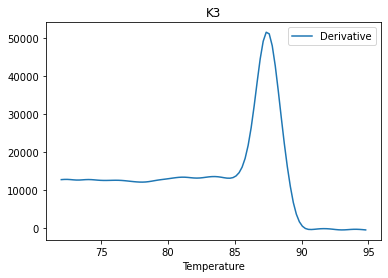

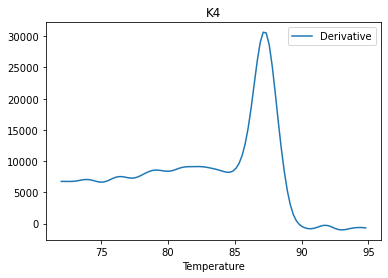

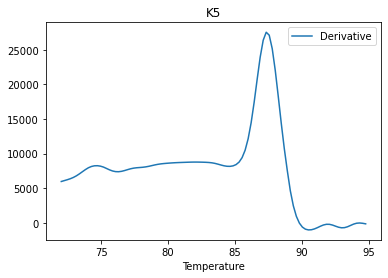

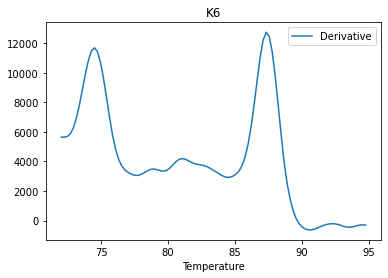

In [85]:
target = 'SpyTag_LMNA'

# print(target)

target_wells   = my_sample_df[my_sample_df['Target Name']==target]

standard_wells = target_wells[target_wells['Task']=='Standard']

for key in standard_wells['Well Position']:

#     print(key)

    melt_curve_df[melt_curve_df['Well Position']==key].plot(x='Temperature', y='Derivative')
    plt.title(key)
    
# B2 - B6 have the side hit
# So do I6 and K6

In [86]:
issue_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'I6', 'K6']

my_sample_df[my_sample_df['Well Position'].isin(issue_list)]

,Unnamed: 0,Unnamed: 0.1,Well,Well Position,Sample Name,Sample Color,Biogroup Name,Biogroup Color,Target Name,Target Color,Task,Reporter,Quencher,Quantity,Comments
25,25,25,26,B2,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.10000,None
26,26,26,27,B3,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.01000,None
27,27,27,28,B4,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.00100,None
28,28,28,29,B5,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.00010,None
29,29,29,30,B6,WT LMNA Plasmid,None,WT LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.00001,None
197,197,197,198,I6,GFP11-SpyT-LMNA Plasmid,None,GFP11-SpyT-LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.00001,None
245,245,245,246,K6,ALFA-SpyT-LMNA Plasmid,None,ALFA-SpyT-LMNA Plasmid,None,SpyTag_LMNA,#60BDCC,Standard,None,None,0.00001,None


In [87]:
## SpyTag_LMNA primers give a week non-specific signal at low annealing temps. Strongest with the WT plasmid

## Step 5 - Organise the plots by experiment

In [88]:
fit_df

,Target Name,Biogroup Name,Target Color,Ct Type,Slope,Intercept,R value,P value,Standard Error
0,ALFA_LMNA,ALFA-LMNA Plasmid,#E59948,Original Ct,-3.553127,10.419796,-0.999164,1.047281e-06,0.072676
1,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,#E59948,Original Ct,-3.808705,10.488753,-0.999429,4.882395e-07,0.064358
2,GFP11_LMNA,GFP11-LMNA Plasmid,#AACF94,Original Ct,-3.717449,10.789487,-0.997798,7.267024e-06,0.123550
3,GFP11_LMNA,GFP11-SpyT-LMNA Plasmid,#AACF94,Original Ct,-4.116008,13.614589,-0.999355,6.237825e-07,0.073949
4,LMNA Internal,WT LMNA Plasmid,dimgrey,Original Ct,-3.956143,10.685050,-0.999710,1.257063e-07,0.047608
5,SpyTag_LMNA,ALFA-SpyT-LMNA Plasmid,#60BDCC,Original Ct,-3.745522,11.874832,-0.999407,5.272379e-07,0.064519
6,SpyTag_LMNA,GFP11-SpyT-LMNA Plasmid,#60BDCC,Original Ct,-3.808848,13.284353,-0.998910,1.781058e-06,0.088986
7,SpyTag_LMNA,SpyT-LMNA Plasmid,#60BDCC,Original Ct,-3.562069,10.616604,-0.999684,1.493535e-07,0.044754
8,ALFA_LMNA,ALFA-LMNA Plasmid,#E59948,Lo thresh Ct,-3.566138,10.337121,-0.999044,1.369358e-06,0.078007
9,ALFA_LMNA,ALFA-SpyT-LMNA Plasmid,#E59948,Lo thresh Ct,-3.814102,10.431306,-0.999440,4.705620e-07,0.063857


In [89]:
my_Ct_results

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,1.0000,10.7819,10.707516636961287,11.206080395526243
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.1000,14.7766,14.689455560537265,15.18939026280521
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.0100,18.2721,18.190679308041165,18.660424630540927
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.0010,22.4681,22.364042970335397,22.91463401116235
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,0.0001,26.6304,26.542662209893862,27.09963702561525
...,...,...,...,...,...,...,...,...,...,...
379,P20,None,None,None,NaN,None,NaN,Undetermined,nan,nan
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


In [90]:
unknowns = my_Ct_results[my_Ct_results['Task'].eq('Unknown')]
unknowns

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Quantity,Original Ct,Lo thresh Ct,Hi thresh Ct
7,A8,AS02 PPI PS sgRNA1 Rep1,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,NaN,25.5584,25.00824558201031,25.46065465506177
8,A9,AS02 PPI PS sgRNA1 Rep2,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,NaN,25.6342,25.109857433226317,25.558861379917513
9,A10,AS02 PPI PS sgRNA2 Rep1,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,NaN,25.6805,25.16645533098514,25.592600693957436
10,A11,AS02 PPI PS sgRNA2 Rep2,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,NaN,26.1656,25.584217419232502,26.07599460090727
13,A14,GS PPI PS sgRNA1 Rep1,GS07 PPI Presort,LMNA Internal,dimgrey,Unknown,NaN,25.0878,24.43157671891215,25.02418038403872
...,...,...,...,...,...,...,...,...,...,...
378,P19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,NaN,26.2364,25.711725812227453,26.206032495688728
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.5364,24.94473930693364,25.487153501977645
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.6383,24.94290398858772,25.563120810983616
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,NaN,25.1406,24.61299581193691,25.125526767065985


In [91]:
unknowns['Biogroup Name'].unique()

array(['AS02 PPI Presort', 'GS07 PPI Presort', 'AS04 Biallelic PS',
       'AS02 PPI', 'AS04 PPI', 'GS07 PPI', 'AS04 Biallelic',
       'WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'AS04 LP PPI Sort',
       'AS04 LP Biallelic Sort', 'GFP11 in GFP(1-10) Presort',
       'GFP11 in GFP(1-10) Sort'], dtype=object)

In [92]:
unknowns['Target Name'].unique()

array(['LMNA Internal', 'SpyTag_LMNA', 'GFP11_LMNA', 'ALFA_LMNA'],
      dtype=object)

In [93]:
## Start with GFP11
target   = 'GFP11_LMNA'
biogroup = 'GFP11-LMNA Plasmid'
Ct_type  = 'Original Ct'

In [170]:
# Write a function for one case
def quantification_df_from_standards(target, biogroup, Ct_type, plot=True):
    
    fit_data = fit_df[(fit_df['Target Name']==target) & (fit_df['Biogroup Name']==biogroup) & (fit_df['Ct Type']==Ct_type)]

    # get slope and intercept from fit_df
    [slope, intercept] = fit_data[['Slope', 'Intercept']].values[0]
    
    # get CT from my_Ct_results
    target_Ct_data = my_Ct_results[(my_Ct_results['Target Name']==target)]
    Ct_data        = target_Ct_data[Ct_type]

    Ct_data        = pd.to_numeric(Ct_data, errors='coerce')
    
    target_quantitation_df = target_Ct_data.iloc[:,0:6].copy()
    target_quantitation_df['Ct Type']  = Ct_type
    target_quantitation_df['log10 (fmol)'] = pd.to_numeric(10**quant_from_CT(Ct_data, slope, intercept), errors='coerce')
    
    color = target_quantitation_df['Target Color'].unique()[0]

    unknowns = target_quantitation_df[target_quantitation_df['Task']!='Standard']
    
    if plot:
        grouped  = unknowns.groupby('Biogroup Name').mean().plot.bar(color=color)
        plt.legend().remove()
        plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);
    
    return target_quantitation_df

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,4.533978e-07
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,1.335933e-07
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,5.808414e-05
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,1.079117e-04
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,1.013094e-04
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,1.378851e-04


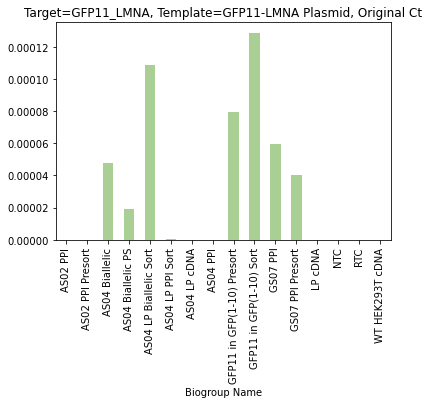

In [95]:
GFP11_LMNA_1 = quantification_df_from_standards(target='GFP11_LMNA', biogroup='GFP11-LMNA Plasmid', Ct_type='Original Ct')
GFP11_LMNA_1

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
48,C1,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,0.000009
49,C2,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,0.000003
50,C3,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN
51,C4,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN
52,C5,WT LMNA Plasmid,WT LMNA Plasmid,GFP11_LMNA,#AACF94,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
354,O19,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,0.000725
380,P21,GFP11 in GFP(1-10) gRNA1 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,0.001269
381,P22,GFP11 in GFP(1-10) gRNA1 Rep2 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,0.001199
382,P23,GFP11 in GFP(1-10) gRNA2 Rep1 Sort,GFP11 in GFP(1-10) Sort,GFP11_LMNA,#AACF94,Unknown,Original Ct,0.001584


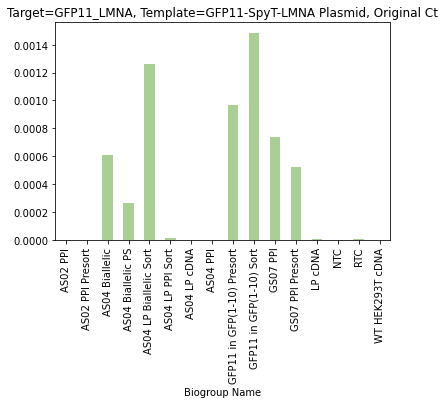

In [96]:
GFP11_LMNA_2 = quantification_df_from_standards(target='GFP11_LMNA', biogroup='GFP11-SpyT-LMNA Plasmid', Ct_type='Original Ct')
GFP11_LMNA_2

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
0,A1,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,Original Ct,9.452083e-01
1,A2,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,Original Ct,9.242318e-02
2,A3,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,Original Ct,1.208367e-02
3,A4,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,Original Ct,1.050967e-03
4,A5,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,Original Ct,9.321038e-05
5,A6,WT LMNA Plasmid,WT LMNA Plasmid,LMNA Internal,dimgrey,Standard,Original Ct,9.670289e-06
7,A8,AS02 PPI PS sgRNA1 Rep1,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,Original Ct,1.739552e-04
8,A9,AS02 PPI PS sgRNA1 Rep2,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,Original Ct,1.664461e-04
9,A10,AS02 PPI PS sgRNA2 Rep1,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,Original Ct,1.620247e-04
10,A11,AS02 PPI PS sgRNA2 Rep2,AS02 PPI Presort,LMNA Internal,dimgrey,Unknown,Original Ct,1.221716e-04


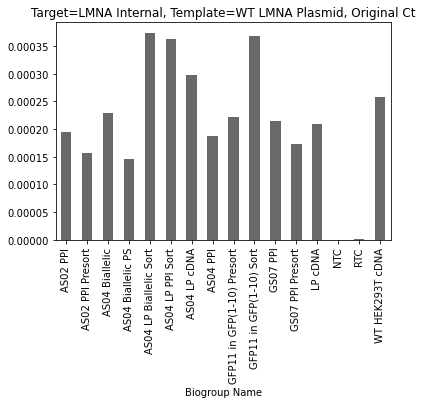

In [171]:
LMNA = quantification_df_from_standards(target='LMNA Internal', biogroup='WT LMNA Plasmid', Ct_type='Original Ct')
LMNA

In [98]:
test = LMNA.groupby('Biogroup Name').agg(['mean', 'std'])

In [99]:
test

log10 (fmol)          
                                    mean       std
Biogroup Name                                     
AS02 PPI                    1.945743e-04  0.000036
AS02 PPI Presort            1.561494e-04  0.000023
AS04 Biallelic              2.295983e-04  0.000037
AS04 Biallelic PS           1.466826e-04  0.000024
AS04 LP Biallelic Sort      3.742503e-04  0.000177
AS04 LP PPI Sort            3.632640e-04  0.000095
AS04 LP cDNA                2.975437e-04  0.000029
AS04 PPI                    1.876653e-04  0.000096
GFP11 in GFP(1-10) Presort  2.227757e-04  0.000060
GFP11 in GFP(1-10) Sort     3.681147e-04  0.000069
GS07 PPI                    2.154049e-04  0.000022
GS07 PPI Presort            1.739554e-04  0.000060
LP cDNA                     2.085015e-04  0.000096
NTC                         2.531766e-07       NaN
RTC                         1.788265e-06       NaN
WT HEK293T cDNA             2.586983e-04  0.000049
WT LMNA Plasmid             1.751448e-01  0.378960

In [100]:
group_order = ['WT HEK293T cDNA', 
              'GFP11 in GFP(1-10) Presort',
              'GFP11 in GFP(1-10) Sort']

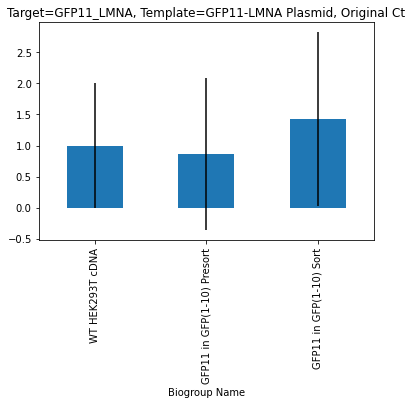

In [101]:
norm = test / test.loc['WT HEK293T cDNA', :]

norm.loc[group_order, :].plot.bar(y=0, yerr=norm.iloc[:,1])
    
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

In [102]:
group_order = ['WT HEK293T cDNA',
               'GFP11 in GFP(1-10) Presort',
               'GFP11 in GFP(1-10) Sort',
               'GS07 PPI Presort',
              'GS07 PPI']

In [103]:
# Plot LMNA with error bars
def plot_quantitation(target_quantitation_df, order, ax=None):
    
    color = target_quantitation_df['Target Color'].unique()[0]

    agg_df  = target_quantitation_df.groupby('Biogroup Name').agg(['mean', 'std'])
    
    #Reorder df
    agg_df.loc[order, :].plot.bar(y=0, yerr=agg_df.iloc[:,1], color=color, ax=ax)
    
    if ax == None:
        plt.legend().remove()
    
    return agg_df

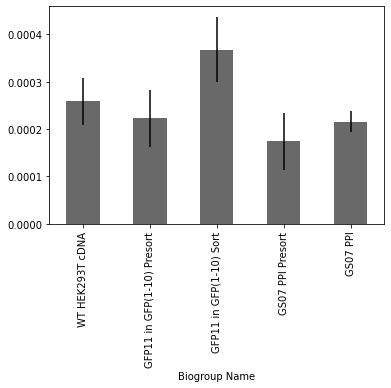

In [104]:
LMNA_agg_df = plot_quantitation(LMNA, group_order);

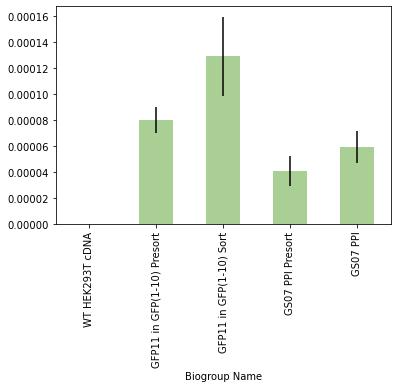

In [105]:
GFP11_LMNA_1_agg_df = plot_quantitation(GFP11_LMNA_1, group_order);

In [106]:
GFP11_LMNA_1_agg_df

log10 (fmol)              
                                    mean           std
Biogroup Name                                         
AS02 PPI                    7.089990e-08  3.173719e-09
AS02 PPI Presort            4.261846e-08           NaN
AS04 Biallelic              4.794181e-05  1.910042e-05
AS04 Biallelic PS           1.927300e-05  3.390620e-06
AS04 LP Biallelic Sort      1.084920e-04  5.367544e-05
AS04 LP PPI Sort            7.068198e-07  5.205585e-07
AS04 LP cDNA                         NaN           NaN
AS04 PPI                    3.979078e-08  5.084892e-09
GFP11 in GFP(1-10) Presort  7.975850e-05  9.731927e-06
GFP11 in GFP(1-10) Sort     1.287378e-04  3.054561e-05
GFP11-LMNA Plasmid          1.605357e-01  3.398523e-01
GFP11-SpyT-LMNA Plasmid     3.569854e-02  8.186840e-02
GS07 PPI                    5.925571e-05  1.240356e-05
GS07 PPI Presort            4.056800e-05  1.120894e-05
LP cDNA                     1.156679e-07  5.100944e-08
NTC                                  NaN           NaN
RTC                         1.203175e-07           NaN
WT HEK293T cDNA             2.544384e-08  1.421719e-08
WT LMNA Plasmid             2.934956e-07  2.261359e-07

In [107]:
LMNA_agg_df

log10 (fmol)          
                                    mean       std
Biogroup Name                                     
AS02 PPI                    1.945743e-04  0.000036
AS02 PPI Presort            1.561494e-04  0.000023
AS04 Biallelic              2.295983e-04  0.000037
AS04 Biallelic PS           1.466826e-04  0.000024
AS04 LP Biallelic Sort      3.742503e-04  0.000177
AS04 LP PPI Sort            3.632640e-04  0.000095
AS04 LP cDNA                2.975437e-04  0.000029
AS04 PPI                    1.876653e-04  0.000096
GFP11 in GFP(1-10) Presort  2.227757e-04  0.000060
GFP11 in GFP(1-10) Sort     3.681147e-04  0.000069
GS07 PPI                    2.154049e-04  0.000022
GS07 PPI Presort            1.739554e-04  0.000060
LP cDNA                     2.085015e-04  0.000096
NTC                         2.531766e-07       NaN
RTC                         1.788265e-06       NaN
WT HEK293T cDNA             2.586983e-04  0.000049
WT LMNA Plasmid             1.751448e-01  0.378960

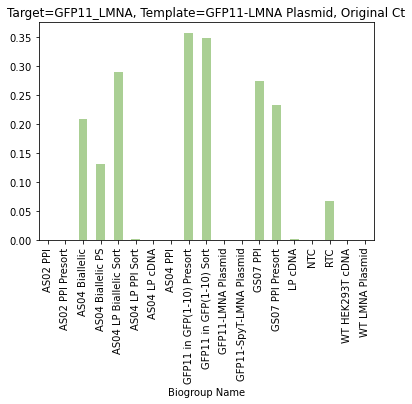

In [108]:
ratio = GFP11_LMNA_1_agg_df / LMNA_agg_df

ratio.plot.bar(y=0, color=color)
    
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

# LMNA primers were not tested on GFP11-LMNA plasmid

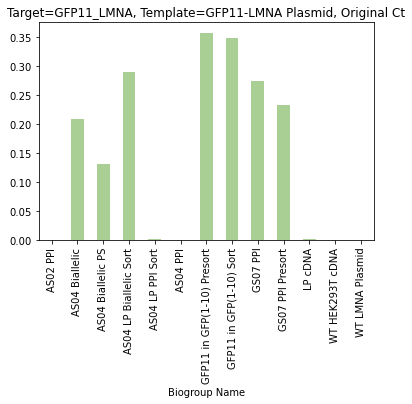

In [109]:
# Using pd.divide we can skip groups that weren't measure with both primers
ratio = GFP11_LMNA_1_agg_df.divide(LMNA_agg_df, fill_value=np.nan)

ratio.dropna().plot.bar(y=0, color=color)
    
plt.legend().remove()
plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);

In [110]:
ratio

log10 (fmol)              
                                   mean           std
Biogroup Name                                        
AS02 PPI                       0.000364  8.820889e-05
AS02 PPI Presort               0.000273           NaN
AS04 Biallelic                 0.208807  5.216302e-01
AS04 Biallelic PS              0.131393  1.405426e-01
AS04 LP Biallelic Sort         0.289892  3.034661e-01
AS04 LP PPI Sort               0.001946  5.502683e-03
AS04 LP cDNA                        NaN           NaN
AS04 PPI                       0.000212  5.285259e-05
GFP11 in GFP(1-10) Presort     0.358022  1.610869e-01
GFP11 in GFP(1-10) Sort        0.349722  4.403886e-01
GFP11-LMNA Plasmid                  NaN           NaN
GFP11-SpyT-LMNA Plasmid             NaN           NaN
GS07 PPI                       0.275090  5.537850e-01
GS07 PPI Presort               0.233209  1.863059e-01
LP cDNA                        0.000555  5.298940e-04
NTC                                 NaN           NaN
RTC                            0.067282           NaN
WT HEK293T cDNA                0.000098  2.873371e-04
WT LMNA Plasmid                0.000002  5.967275e-07

In [111]:
LMNA_agg_df

log10 (fmol)          
                                    mean       std
Biogroup Name                                     
AS02 PPI                    1.945743e-04  0.000036
AS02 PPI Presort            1.561494e-04  0.000023
AS04 Biallelic              2.295983e-04  0.000037
AS04 Biallelic PS           1.466826e-04  0.000024
AS04 LP Biallelic Sort      3.742503e-04  0.000177
AS04 LP PPI Sort            3.632640e-04  0.000095
AS04 LP cDNA                2.975437e-04  0.000029
AS04 PPI                    1.876653e-04  0.000096
GFP11 in GFP(1-10) Presort  2.227757e-04  0.000060
GFP11 in GFP(1-10) Sort     3.681147e-04  0.000069
GS07 PPI                    2.154049e-04  0.000022
GS07 PPI Presort            1.739554e-04  0.000060
LP cDNA                     2.085015e-04  0.000096
NTC                         2.531766e-07       NaN
RTC                         1.788265e-06       NaN
WT HEK293T cDNA             2.586983e-04  0.000049
WT LMNA Plasmid             1.751448e-01  0.378960

## Biallelic Figure Plot

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
72,D1,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,2.203014e-06
73,D2,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,5.260797e-08
74,D3,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,NaN
75,D4,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,NaN
76,D5,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
373,P14,AS04 LP PPI Sort 2,AS04 LP PPI Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,6.863930e-05
375,P16,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,8.637712e-05
376,P17,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,1.020003e-04
377,P18,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,4.184218e-05


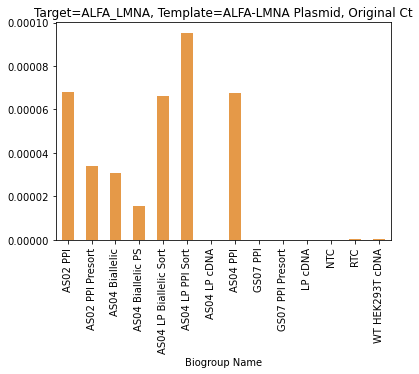

In [112]:
ALFA_1 = quantification_df_from_standards(target='ALFA_LMNA', biogroup='ALFA-LMNA Plasmid', Ct_type='Original Ct')
ALFA_1

In [113]:
ALFA_1['Biogroup Name'].unique()

array(['WT LMNA Plasmid', 'AS02 PPI Presort', 'GS07 PPI Presort',
       'AS04 Biallelic PS', 'ALFA-LMNA Plasmid', 'AS02 PPI', 'AS04 PPI',
       'GS07 PPI', 'AS04 Biallelic', 'ALFA-SpyT-LMNA Plasmid',
       'WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'NTC', 'RTC',
       'AS04 LP PPI Sort', 'AS04 LP Biallelic Sort'], dtype=object)

In [114]:
biallelic_group_order = ['WT HEK293T cDNA', 'AS04 Biallelic PS', 'AS04 Biallelic', 'AS04 LP Biallelic Sort', 'AS04 LP cDNA', 'LP cDNA', 'RTC', 'NTC', 'AS04 LP PPI Sort', 'GS07 PPI']

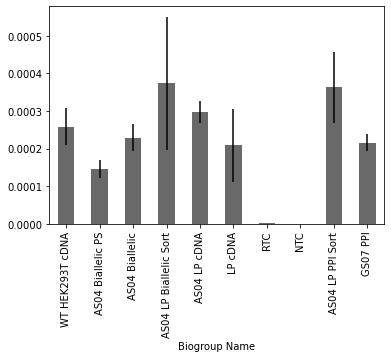

In [115]:
LMNA_for_bi = plot_quantitation(LMNA, biallelic_group_order)

In [116]:
LMNA_for_bi

log10 (fmol)          
                                    mean       std
Biogroup Name                                     
AS02 PPI                    1.945743e-04  0.000036
AS02 PPI Presort            1.561494e-04  0.000023
AS04 Biallelic              2.295983e-04  0.000037
AS04 Biallelic PS           1.466826e-04  0.000024
AS04 LP Biallelic Sort      3.742503e-04  0.000177
AS04 LP PPI Sort            3.632640e-04  0.000095
AS04 LP cDNA                2.975437e-04  0.000029
AS04 PPI                    1.876653e-04  0.000096
GFP11 in GFP(1-10) Presort  2.227757e-04  0.000060
GFP11 in GFP(1-10) Sort     3.681147e-04  0.000069
GS07 PPI                    2.154049e-04  0.000022
GS07 PPI Presort            1.739554e-04  0.000060
LP cDNA                     2.085015e-04  0.000096
NTC                         2.531766e-07       NaN
RTC                         1.788265e-06       NaN
WT HEK293T cDNA             2.586983e-04  0.000049
WT LMNA Plasmid             1.751448e-01  0.378960

In [117]:
relative_LMNA_for_bi = LMNA_for_bi/LMNA_for_bi.loc['WT HEK293T cDNA',:]
relative_LMNA_for_bi

log10 (fmol)             
                                   mean          std
Biogroup Name                                       
AS02 PPI                       0.752128     0.727167
AS02 PPI Presort               0.603596     0.468501
AS04 Biallelic                 0.887514     0.740045
AS04 Biallelic PS              0.567002     0.487583
AS04 LP Biallelic Sort         1.446667     3.574730
AS04 LP PPI Sort               1.404199     1.911934
AS04 LP cDNA                   1.150157     0.585194
AS04 PPI                       0.725421     1.944434
GFP11 in GFP(1-10) Presort     0.861141     1.221002
GFP11 in GFP(1-10) Sort        1.422949     1.401814
GS07 PPI                       0.832649     0.452671
GS07 PPI Presort               0.672426     1.215951
LP cDNA                        0.805964     1.945536
NTC                            0.000979          NaN
RTC                            0.006913          NaN
WT HEK293T cDNA                1.000000     1.000000
WT LMNA Plasmid              677.023417  7658.984936

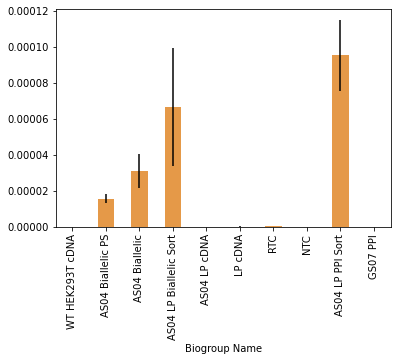

In [118]:
ALFA_for_bi = plot_quantitation(ALFA_1, biallelic_group_order)

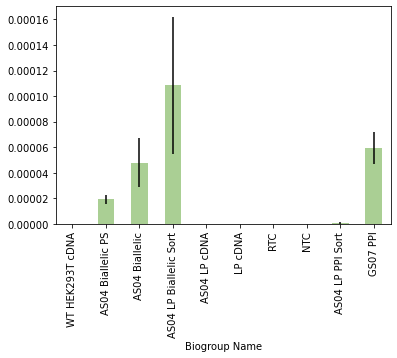

In [119]:
GFP_for_bi = plot_quantitation(GFP11_LMNA_1, biallelic_group_order)

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
24,B1,WT LMNA Plasmid,WT LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,Original Ct,0.000002
25,B2,WT LMNA Plasmid,WT LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,Original Ct,0.000002
26,B3,WT LMNA Plasmid,WT LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,Original Ct,0.000001
27,B4,WT LMNA Plasmid,WT LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,Original Ct,0.000002
28,B5,WT LMNA Plasmid,WT LMNA Plasmid,SpyTag_LMNA,#60BDCC,Standard,Original Ct,0.000002
...,...,...,...,...,...,...,...,...
325,N14,AS04 LP PPI Sort 2,AS04 LP PPI Sort,SpyTag_LMNA,#60BDCC,Unknown,Original Ct,0.000033
327,N16,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,SpyTag_LMNA,#60BDCC,Unknown,Original Ct,0.000151
328,N17,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,SpyTag_LMNA,#60BDCC,Unknown,Original Ct,0.000111
329,N18,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,SpyTag_LMNA,#60BDCC,Unknown,Original Ct,0.000050


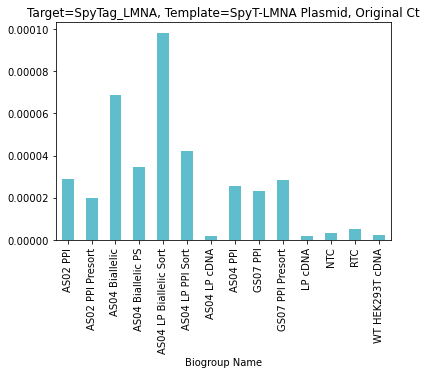

In [120]:
SpyT_1 = quantification_df_from_standards(target='SpyTag_LMNA', biogroup='SpyT-LMNA Plasmid', Ct_type='Original Ct')
SpyT_1

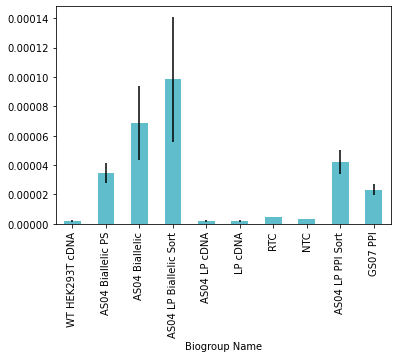

In [121]:
SpyT_for_bi = plot_quantitation(SpyT_1, biallelic_group_order)

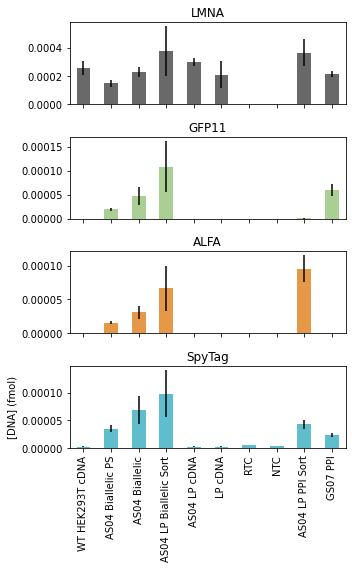

In [122]:
## Plot with shared x axis.

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(5,8))

plot_quantitation(LMNA, biallelic_group_order, ax=axes[0]);
axes[0].legend().remove()
axes[0].set_title('LMNA')

plot_quantitation(GFP11_LMNA_1, biallelic_group_order, ax=axes[1]);
axes[1].legend().remove()
axes[1].set_title('GFP11')

plot_quantitation(ALFA_1, biallelic_group_order, ax=axes[2]);
axes[2].legend().remove()
axes[2].set_title('ALFA')

plot_quantitation(SpyT_1, biallelic_group_order, ax=axes[3]);
axes[3].legend().remove()
axes[3].set_title('SpyTag')

plt.xlabel(None);
plt.ylabel('[DNA] (fmol)');
plt.tight_layout()

In [123]:
biallelic_ratio_order = ['WT HEK293T cDNA', 'AS04 Biallelic PS', 'AS04 Biallelic', 'AS04 LP Biallelic Sort', 'AS04 LP cDNA', 'LP cDNA', 'AS04 LP PPI Sort', 'GS07 PPI']

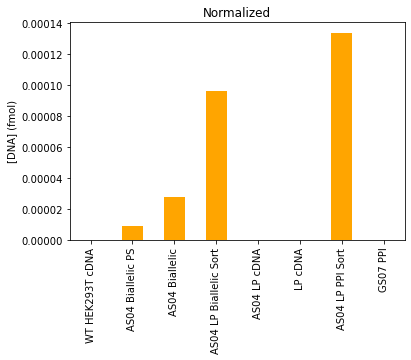

In [124]:
ALFA_ratio = ALFA_for_bi * relative_LMNA_for_bi

ALFA_ratio.loc[biallelic_ratio_order, :].plot.bar(y=0, color='orange')
    
plt.legend().remove()
plt.title('Normalized');
plt.xlabel(None);
plt.ylabel('[DNA] (fmol)');

In [125]:
ALFA_ratio.loc[biallelic_group_order, :]

log10 (fmol)              
                                mean           std
Biogroup Name                                     
WT HEK293T cDNA         1.390867e-07           NaN
AS04 Biallelic PS       8.865016e-06  1.254554e-06
AS04 Biallelic          2.745770e-05  6.998508e-06
AS04 LP Biallelic Sort  9.605193e-05  1.173494e-04
AS04 LP cDNA            5.813172e-08  1.587104e-08
LP cDNA                 8.971496e-08  2.265064e-07
RTC                     1.861992e-09           NaN
NTC                              NaN           NaN
AS04 LP PPI Sort        1.338843e-04  3.793891e-05
GS07 PPI                9.644405e-08  2.186781e-08

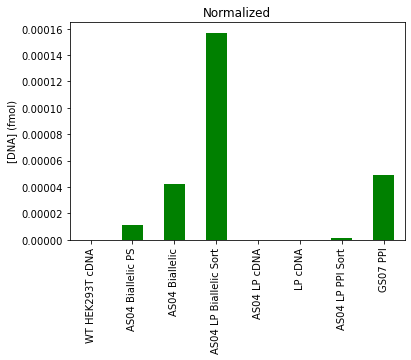

In [126]:
GFP_ratio = GFP_for_bi * relative_LMNA_for_bi

GFP_ratio.loc[biallelic_ratio_order, :].plot.bar(y=0, color='green')
    
plt.legend().remove()
plt.title('Normalized');
plt.xlabel(None);
plt.ylabel('[DNA] (fmol)');

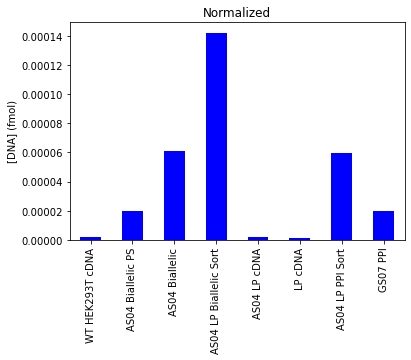

In [127]:
Spy_ratio = SpyT_for_bi * relative_LMNA_for_bi

Spy_ratio.loc[biallelic_ratio_order, :].plot.bar(y=0, color='blue')
    
plt.legend().remove()
plt.title('Normalized');
plt.xlabel(None);
plt.ylabel('[DNA] (fmol)');

In [128]:
GFP11_enrichment = GFP_ratio.loc['AS04 Biallelic', :] / GFP_ratio.loc['AS04 Biallelic PS', :]
GFP11_enrichment

log10 (fmol)  mean    3.893635
              std     8.550133
dtype: float64

In [129]:
ALFA_enrichment = ALFA_ratio.loc['AS04 Biallelic', :] / ALFA_ratio.loc['AS04 Biallelic PS', :]
ALFA_enrichment

log10 (fmol)  mean    3.097310
              std     5.578484
dtype: float64

## How should we present this data?

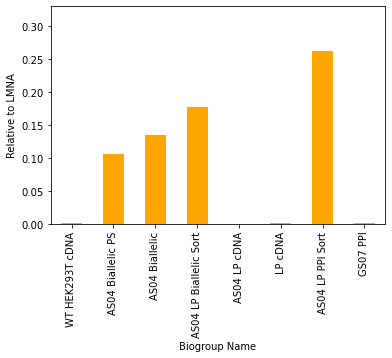

In [130]:
ALFA_ratio = ALFA_for_bi / LMNA_for_bi

ALFA_ratio.loc[biallelic_ratio_order, :].plot.bar(y=0, color='orange')
    
plt.legend().remove()
plt.ylim(0, 0.33);
plt.ylabel('Relative to LMNA');

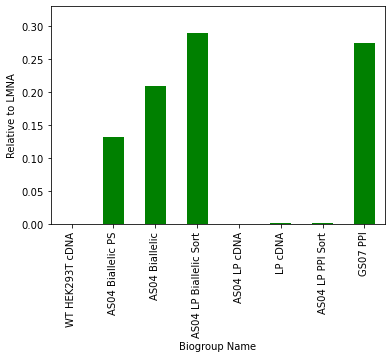

In [131]:
GFP_ratio = GFP_for_bi / LMNA_for_bi

GFP_ratio.loc[biallelic_ratio_order, :].plot.bar(y=0, color='green')
    
plt.legend().remove()
plt.ylim(0, 0.33);
plt.ylabel('Relative to LMNA');

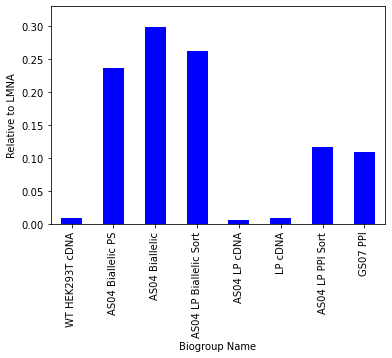

In [132]:
Spy_ratio = SpyT_for_bi / LMNA_for_bi

Spy_ratio.loc[biallelic_ratio_order, :].plot.bar(y=0, color='blue')
    
plt.legend().remove()
plt.ylim(0, 0.33);
plt.ylabel('Relative to LMNA');

In [133]:
# Can we get the std for these plots

In [134]:
# Plot LMNA with error bars
def plot_quantitation(target_quantitation_df, order, ax=None):
    
    color = target_quantitation_df['Target Color'].unique()[0]

    agg_df  = target_quantitation_df.groupby('Biogroup Name').agg(['mean', 'std'])
    
    #Reorder df
    agg_df.loc[order, :].plot.bar(y=0, yerr=agg_df.iloc[:,1], color=color, ax=ax)
    
    if ax == None:
        plt.legend().remove()
        plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);
    
    return agg_df

,Well Position,Sample Name,Biogroup Name,Target Name,Target Color,Task,Ct Type,log10 (fmol)
72,D1,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,2.203014e-06
73,D2,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,5.260797e-08
74,D3,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,NaN
75,D4,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,NaN
76,D5,WT LMNA Plasmid,WT LMNA Plasmid,ALFA_LMNA,#E59948,Standard,Original Ct,NaN
...,...,...,...,...,...,...,...,...
373,P14,AS04 LP PPI Sort 2,AS04 LP PPI Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,6.863930e-05
375,P16,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,8.637712e-05
376,P17,AS04 LP Biallelic Sort 2,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,1.020003e-04
377,P18,AS04 LP Biallelic Sort 1,AS04 LP Biallelic Sort,ALFA_LMNA,#E59948,Unknown,Original Ct,4.184218e-05


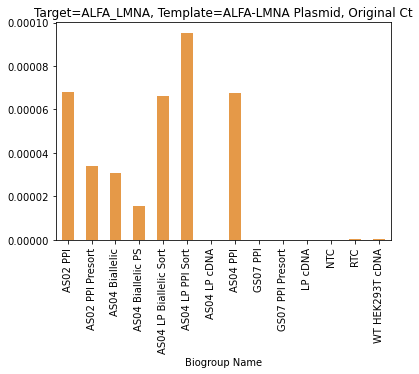

In [135]:
ALFA_1 = quantification_df_from_standards(target='ALFA_LMNA', biogroup='ALFA-LMNA Plasmid', Ct_type='Original Ct')
ALFA_1

In [209]:
def plot_normalised(target1, biogroup1, norm_target, norm_biogroup, Ct_type, group_order, ax=None, horizontal=False):
    
    numerator   = quantification_df_from_standards(target=target1, biogroup=biogroup1, Ct_type=Ct_type, plot=False);
    
    color = numerator['Target Color'].unique()[0]
    
    denominator = quantification_df_from_standards(target=norm_target, biogroup=norm_biogroup, Ct_type=Ct_type, plot=False)
    
    merged = numerator.merge(denominator, on=['Sample Name', 'Biogroup Name'])
    
    ratio = merged['log10 (fmol)_x']/merged['log10 (fmol)_y']

    ratio_df = merged.loc[:, ['Sample Name', 'Biogroup Name']]
    ratio_df['ratio'] = ratio
    
    ratio_agg_df = ratio_df.groupby(by='Biogroup Name').agg(['mean', 'std'])
    
    if horizontal:
        group_order = reversed(group_order)
        ratio_agg_df.loc[group_order, :].plot.barh(y=0, xerr=ratio_agg_df.iloc[:,1], color=color, ax=ax);
        plt.legend().remove();
        plt.xlim(0,1);
        plt.ylabel(None);
        
    else:
        ratio_agg_df.loc[group_order, :].plot.bar(y=0, yerr=ratio_agg_df.iloc[:,1], color=color, ax=ax);
        plt.legend().remove();
        plt.ylim(0,1);
        plt.xlabel(None);

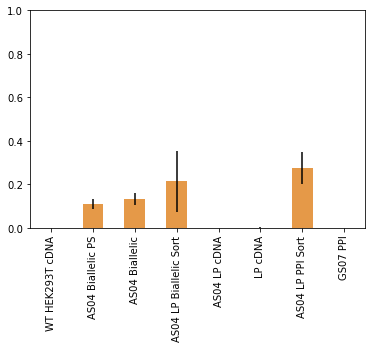

In [202]:
plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', biallelic_ratio_order)

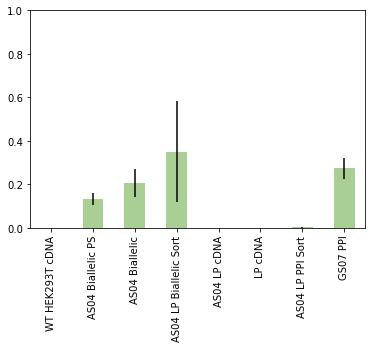

In [204]:
plot_normalised('GFP11_LMNA', 'GFP11-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', biallelic_ratio_order)

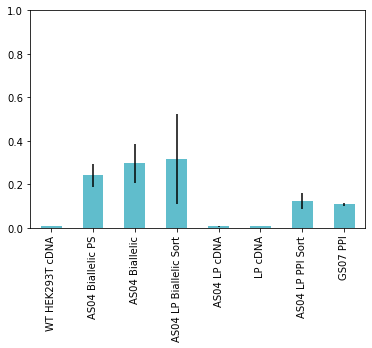

In [176]:
plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', biallelic_ratio_order)

In [140]:
PPI_order = ['WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'AS04 LP PPI Sort', 'AS04 PPI', 'NTC', 'RTC', 'GS07 PPI Presort', 'GS07 PPI']

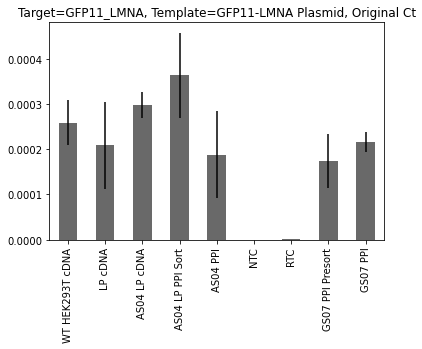

In [141]:
LMNA_for_PPI = plot_quantitation(LMNA, PPI_order)
plt.xlabel(None);

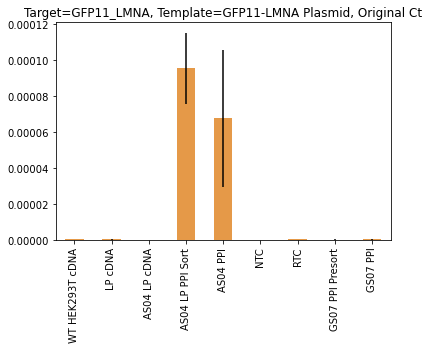

In [142]:
ALFA_for_PPI = plot_quantitation(ALFA_1, PPI_order)
plt.xlabel(None);

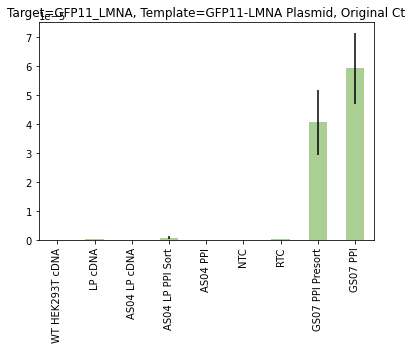

In [143]:
GFP11_for_PPI = plot_quantitation(GFP11_LMNA_1, PPI_order)
plt.xlabel(None);

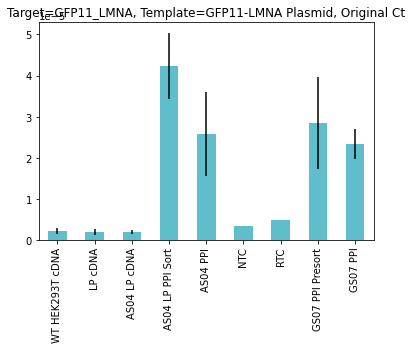

In [144]:
SpyT_for_PPI = plot_quantitation(SpyT_1, PPI_order)
plt.xlabel(None);

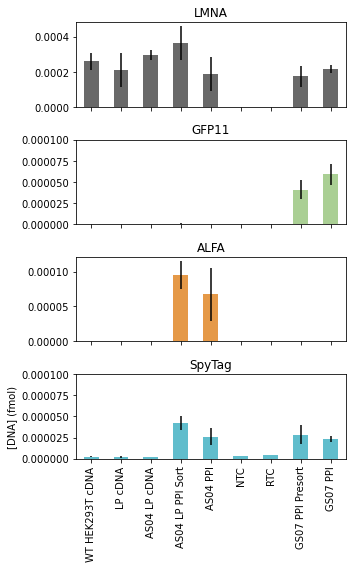

In [145]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(5,8))

plot_quantitation(LMNA, PPI_order, ax=axes[0]);
axes[0].legend().remove()
axes[0].set_title('LMNA')

plot_quantitation(GFP11_LMNA_1, PPI_order, ax=axes[1]);
axes[1].legend().remove()
axes[1].set_title('GFP11')
axes[1].set_ylim(0,0.0001)

plot_quantitation(ALFA_1, PPI_order, ax=axes[2]);
axes[2].legend().remove()
axes[2].set_title('ALFA')

plot_quantitation(SpyT_1, PPI_order, ax=axes[3]);
axes[3].legend().remove()
axes[3].set_title('SpyTag')
axes[3].set_ylim(0,0.0001)

plt.xlabel(None);
plt.ylabel('[DNA] (fmol)');
plt.tight_layout()

In [146]:
PPI_order = ['WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'AS04 LP PPI Sort', 'AS04 PPI', 'RTC', 'NTC']

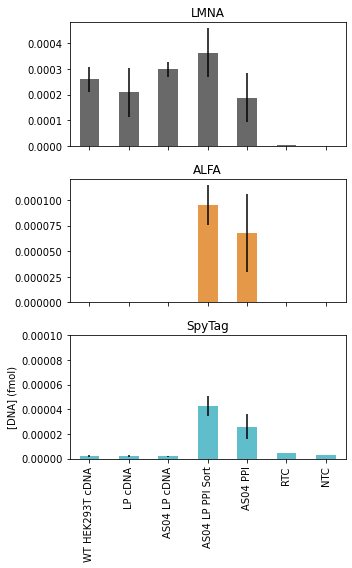

In [147]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,8))

plot_quantitation(LMNA, PPI_order, ax=axes[0]);
axes[0].legend().remove()
axes[0].set_title('LMNA')

plot_quantitation(ALFA_1, PPI_order, ax=axes[1]);
axes[1].legend().remove()
axes[1].set_title('ALFA')

plot_quantitation(SpyT_1, PPI_order, ax=axes[2]);
axes[2].legend().remove()
axes[2].set_title('SpyTag')
axes[2].set_ylim(0,0.0001)

plt.xlabel(None);
plt.ylabel('[DNA] (fmol)');
plt.tight_layout()

In [148]:
# Relabel the x axis
x_labels = ['WT', 'master', 'AS04 cells', 'AS04 cells + KI', 'WT + KI + AS04 BLU', 'RTC', 'NTC']

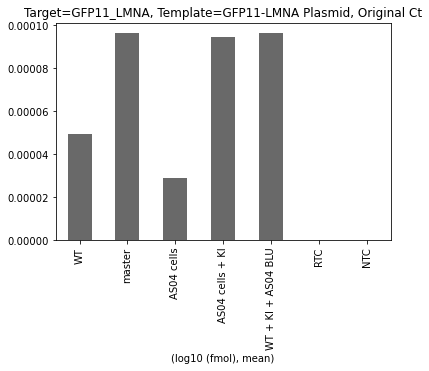

In [152]:
plot_quantitation(LMNA, PPI_order)
plt.xticks(ticks=range(len(x_labels)), labels=x_labels);

In [158]:
# Plot LMNA with error bars
def plot_quantitation(target_quantitation_df, order, ax=None, horizontal=False):
    
    color = target_quantitation_df['Target Color'].unique()[0]

    agg_df  = target_quantitation_df.groupby('Biogroup Name').agg(['mean', 'std'])
    
    #Reorder df
    if horizontal:
        order = reversed(order)
        agg_df.loc[order, :].plot.barh(y=0, yerr=agg_df.iloc[:,1], color=color, ax=ax)
    else:
        agg_df.loc[order, :].plot.bar(x=0, xerr=agg_df.iloc[:,1], color=color, ax=ax)
    
    if ax == None:
        plt.legend().remove()
        plt.title('Target='+target+', Template='+biogroup+', '+Ct_type);
    
    return agg_df

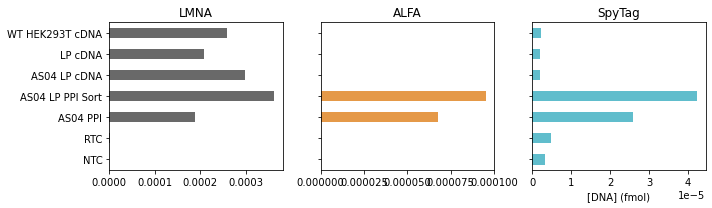

In [162]:
# Horizontal bar plot (Need to reverse bar order, and plot relative)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,3))

plot_quantitation(LMNA, PPI_order, ax=axes[0], horizontal=True);
axes[0].legend().remove()
axes[0].set_title('LMNA')

plot_quantitation(ALFA_1, PPI_order, ax=axes[1], horizontal=True);
axes[1].legend().remove()
axes[1].set_title('ALFA')

plot_quantitation(SpyT_1, PPI_order, ax=axes[2], horizontal=True);
axes[2].legend().remove()
axes[2].set_title('SpyTag')

axes[0].set_ylabel(None);
plt.xlabel('[DNA] (fmol)');
plt.tight_layout()

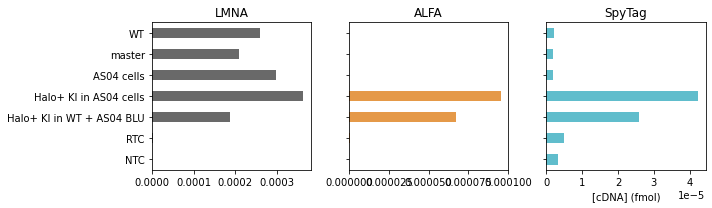

In [189]:
# Horizontal bar plot (Need to reverse bar order, and plot relative)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,3))

plot_quantitation(LMNA, PPI_order, ax=axes[0], horizontal=True);
axes[0].legend().remove()
axes[0].set_title('LMNA')

plot_quantitation(ALFA_1, PPI_order, ax=axes[1], horizontal=True);
axes[1].legend().remove()
axes[1].set_title('ALFA')

plot_quantitation(SpyT_1, PPI_order, ax=axes[2], horizontal=True);
axes[2].legend().remove()
axes[2].set_title('SpyTag')

axes[0].set_ylabel(None);
axes[0].set_yticklabels(labels=reversed(['WT', 'master', 'AS04 cells', 'Halo+ KI in AS04 cells', 'Halo+ KI in WT + AS04 BLU', 'RTC', 'NTC']));

plt.xlabel('[cDNA] (fmol)');
plt.tight_layout()

In [185]:
PPI_order

['WT HEK293T cDNA',
 'LP cDNA',
 'AS04 LP cDNA',
 'AS04 LP PPI Sort',
 'AS04 PPI',
 'RTC',
 'NTC']

In [186]:
PPI_order[:-2]

['WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'AS04 LP PPI Sort', 'AS04 PPI']

In [191]:
def std_for_ratios(numerator, denominator):
    '''
    
    Returns:
    z: 
    mean
    
    new_stds:
    new standard deviations
    
    '''
    
    z = numerator['mean'] / denominator['mean'].item()

    Dz_over_z = np.sqrt(numerator['std']/numerator['mean'])**2 + (denominator['std'].item()/denominator['mean'].item())**2

    new_stds = Dz_over_z * z
    
    return z, new_stds

In [192]:
def relative_to_biogroup(target_quantitation_df: pd.DataFrame, biogroup: str):
    '''
    Calculate means and standard deviation, relative to a given biogroup.
    
    '''
    
    color = target_quantitation_df['Target Color'].unique()[0]
    
    #Exclude standards
    numerator  = target_quantitation_df.groupby('Biogroup Name').agg(['count', 'mean', 'std'])
    numerator.columns = numerator.columns.droplevel(0)
    
    denominator = target_quantitation_df[target_quantitation_df['Biogroup Name']==biogroup].groupby('Biogroup Name').agg(['count', 'mean', 'std'])
    denominator.columns = denominator.columns.droplevel(0)
    
    z, new_stds = std_for_ratios(numerator, denominator)
    
    return z, new_stds

['WT HEK293T cDNA',
 'LP cDNA',
 'AS04 LP cDNA',
 'AS04 LP PPI Sort',
 'AS04 PPI',
 'RTC',
 'NTC']

In [260]:
PPI_order = ['WT HEK293T cDNA', 'LP cDNA', 'AS04 LP cDNA', 'AS04 LP PPI Sort', 'AS04 PPI']
labels = ['WT', 'master', 'AS04 cells', 'AS04 cells + KI', 'WT + KI + AS04 BLU']

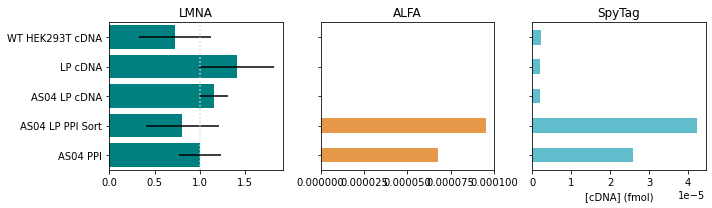

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[PPI_order].index, width=z[PPI_order], xerr=new_stds[PPI_order], color='teal');
axes[0].set_yticklabels(reversed(labels));
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
# axes[0].legend().remove()
axes[0].set_title('LMNA')

plot_quantitation(ALFA_1, PPI_order, ax=axes[1], horizontal=True);
axes[1].legend().remove()
axes[1].set_title('ALFA')

plot_quantitation(SpyT_1, PPI_order, ax=axes[2], horizontal=True);
axes[2].legend().remove()
axes[2].set_title('SpyTag')

axes[0].set_ylabel(None);

plt.xlabel('[cDNA] (fmol)');
plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


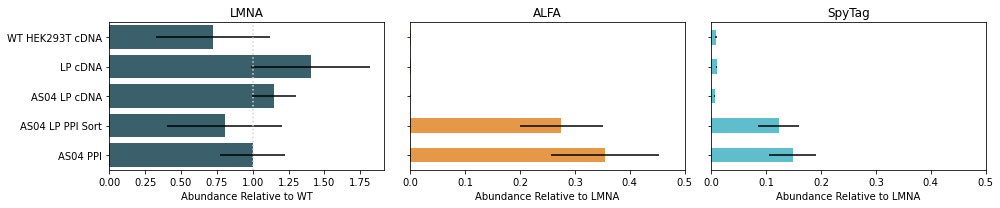

In [234]:
# Relative plots for ALFA and SpyTag

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[PPI_order].index, width=z[PPI_order], xerr=new_stds[PPI_order], color='#3A616B');
axes[0].set_yticks(range(len(labels)));
axes[0].set_yticklabels(reversed(labels));
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
axes[0].legend().remove()
axes[0].set_title('LMNA')
axes[0].set_xlabel('Abundance Relative to WT');

plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[1], horizontal=True)
axes[1].legend().remove()
axes[1].set_title('ALFA')
axes[1].set_xlim(0, 0.5)
axes[1].set_xlabel('Abundance Relative to LMNA');

plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[2], horizontal=True)
axes[2].legend().remove()
axes[2].set_title('SpyTag')
axes[2].set_xlim(0, 0.5)
axes[2].set_xlabel('Abundance Relative to LMNA');

axes[0].set_ylabel(None);
plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


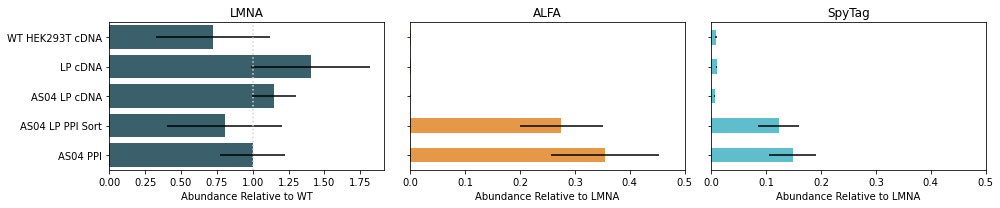

In [246]:
# Relative plots for ALFA and SpyTag
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[PPI_order].index, width=z[PPI_order], xerr=new_stds[PPI_order], color='#3A616B');
axes[0].set_yticks(range(len(labels)));
axes[0].set_yticklabels(labels);
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
axes[0].legend().remove()
axes[0].set_title('LMNA')
axes[0].set_xlabel('Abundance Relative to WT');
axes[0].invert_yaxis()

plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[1], horizontal=True)
axes[1].legend().remove()
axes[1].set_title('ALFA')
axes[1].set_xlim(0, 0.5)
axes[1].set_xlabel('Abundance Relative to LMNA');

plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[2], horizontal=True)
axes[2].set_title('SpyTag')
axes[2].set_xlim(0, 0.5)
axes[2].set_xlabel('Abundance Relative to LMNA');

plt.tight_layout()

No handles with labels found to put in legend.


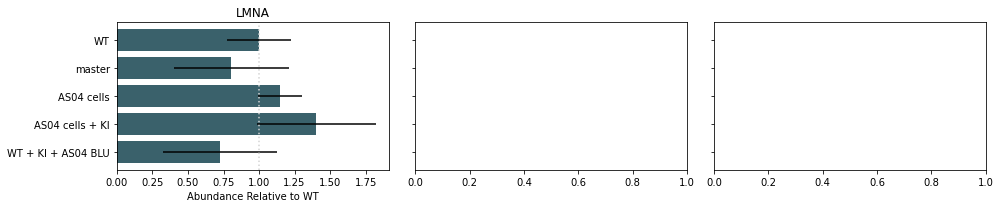

In [248]:
# Relative plots for ALFA and SpyTag
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[PPI_order].index, width=z[PPI_order], xerr=new_stds[PPI_order], color='#3A616B');
axes[0].set_yticks(range(len(labels)));
axes[0].set_yticklabels(labels);
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
axes[0].legend().remove()
axes[0].set_title('LMNA')
axes[0].set_xlabel('Abundance Relative to WT');
axes[0].invert_yaxis()

# plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[1], horizontal=True)
# axes[1].legend().remove()
# axes[1].set_title('ALFA')
# axes[1].set_xlim(0, 0.5)
# axes[1].set_xlabel('Abundance Relative to LMNA');

# plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[2], horizontal=True)
# axes[2].set_title('SpyTag')
# axes[2].set_xlim(0, 0.5)
# axes[2].set_xlabel('Abundance Relative to LMNA');

plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


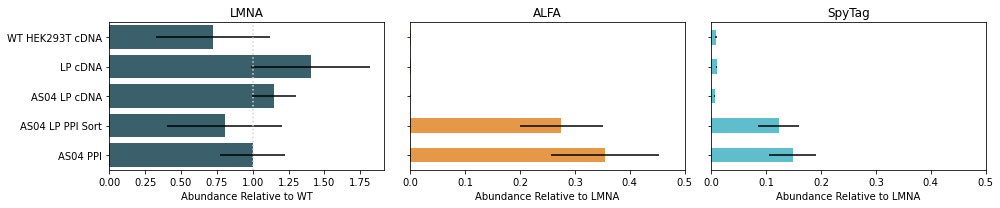

In [250]:
# Relative plots for ALFA and SpyTag
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[PPI_order].index, width=z[PPI_order], xerr=new_stds[PPI_order], color='#3A616B');
axes[0].set_yticks(range(len(labels)));
axes[0].set_yticklabels(labels);
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
axes[0].legend().remove()
axes[0].set_title('LMNA')
axes[0].set_xlabel('Abundance Relative to WT');
axes[0].invert_yaxis()

plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[1], horizontal=True)
axes[1].legend().remove()
axes[1].set_title('ALFA')
axes[1].set_xlim(0, 0.5)
axes[1].set_xlabel('Abundance Relative to LMNA');

plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[2], horizontal=True)
axes[2].set_title('SpyTag')
axes[2].set_xlim(0, 0.5)
axes[2].set_xlabel('Abundance Relative to LMNA');

plt.tight_layout()

In [252]:
z

Biogroup Name
AS02 PPI                        0.752128
AS02 PPI Presort                0.603596
AS04 Biallelic                  0.887514
AS04 Biallelic PS               0.567002
AS04 LP Biallelic Sort          1.446667
AS04 LP PPI Sort                1.404199
AS04 LP cDNA                    1.150157
AS04 PPI                        0.725421
GFP11 in GFP(1-10) Presort      0.861141
GFP11 in GFP(1-10) Sort         1.422949
GS07 PPI                        0.832649
GS07 PPI Presort                0.672426
LP cDNA                         0.805964
NTC                             0.000979
RTC                             0.006913
WT HEK293T cDNA                 1.000000
WT LMNA Plasmid               677.023417
Name: mean, dtype: float64

In [253]:
z[PPI_order]

Biogroup Name
WT HEK293T cDNA     1.000000
LP cDNA             0.805964
AS04 LP cDNA        1.150157
AS04 LP PPI Sort    1.404199
AS04 PPI            0.725421
Name: mean, dtype: float64

In [254]:
z[reversed(PPI_order)]

Biogroup Name
AS04 PPI            0.725421
AS04 LP PPI Sort    1.404199
AS04 LP cDNA        1.150157
LP cDNA             0.805964
WT HEK293T cDNA     1.000000
Name: mean, dtype: float64

No handles with labels found to put in legend.
No handles with labels found to put in legend.


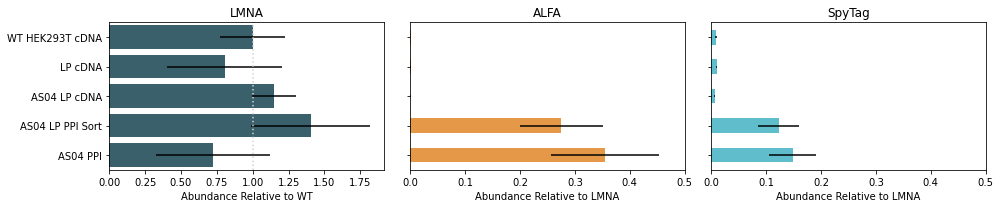

In [256]:
# Relative plots for ALFA and SpyTag
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[reversed(PPI_order)].index, width=z[reversed(PPI_order)], xerr=new_stds[reversed(PPI_order)], color='#3A616B');
# axes[0].set_yticks(range(len(labels)));
# axes[0].set_yticklabels(labels);
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
axes[0].legend().remove()
axes[0].set_title('LMNA')
axes[0].set_xlabel('Abundance Relative to WT');

plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[1], horizontal=True)
axes[1].legend().remove()
axes[1].set_title('ALFA')
axes[1].set_xlim(0, 0.5)
axes[1].set_xlabel('Abundance Relative to LMNA');

plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[2], horizontal=True)
axes[2].set_title('SpyTag')
axes[2].set_xlim(0, 0.5)
axes[2].set_xlabel('Abundance Relative to LMNA');

plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


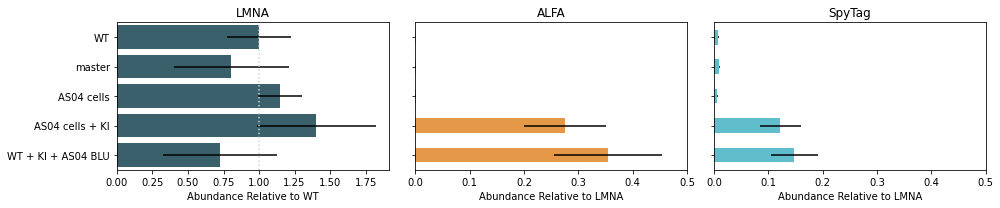

In [266]:
# Relative plots for ALFA and SpyTag
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,3))

z, new_stds = relative_to_biogroup(target_quantitation_df=LMNA, biogroup='WT HEK293T cDNA')

axes[0].barh(y = z[reversed(PPI_order)].index, width=z[reversed(PPI_order)], xerr=new_stds[reversed(PPI_order)], color='#3A616B');
axes[0].axvline(1, c='lightgrey', linestyle='dotted');
axes[0].legend().remove()
axes[0].set_title('LMNA')
axes[0].set_xlabel('Abundance Relative to WT');

plot_normalised('ALFA_LMNA', 'ALFA-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[1], horizontal=True)
axes[1].legend().remove()
axes[1].set_title('ALFA')
axes[1].set_xlim(0, 0.5)
axes[1].set_xlabel('Abundance Relative to LMNA');

plot_normalised('SpyTag_LMNA', 'SpyT-LMNA Plasmid', 'LMNA Internal','WT LMNA Plasmid', 'Original Ct', PPI_order, ax=axes[2], horizontal=True)
axes[2].set_title('SpyTag')
axes[2].set_xlim(0, 0.5)
axes[2].set_xlabel('Abundance Relative to LMNA');

plt.yticks(ticks=range(len(labels)), labels=reversed(labels));
plt.tight_layout()

In [259]:
list(axes[0].get_yticks())

[0, 1, 2, 3, 4]

In [261]:
labels = ['WT', 'master', 'AS04 cells', 'AS04 cells + KI', 'WT + KI + AS04 BLU']